In [3]:
import os
import urllib.request
import zipfile
from functools import partial

import pandas as pd
import xarray as xr
import pynncml

from pynncml.datasets.dataset import LinkDataset
from pynncml.datasets.gauge_data import PointSensor
from pynncml.datasets import PointSet
import numpy as np
import netCDF4 as nc

from pynncml.datasets.xarray_processing import xarray2link, LinkSelection

In [4]:
import os
from pathlib import Path

# find the OpenMesh-1 root automatically
root = Path.cwd()

while root.name != "OpenMesh_pynncml":
    root = root.parent

os.chdir(root)
print("Working directory set to:", root)


Working directory set to: c:\Users\gabir\Documents\Columbia\Research\OpenMesh_pynncml


Import file

In [6]:
# links data
linkspath = r"src\data\openmesh\extracted\dataset\links\ds_openmesh.nc"
with xr.open_dataset(linkspath) as ds:
    pass
# links metadata
metapath = r"src\data\openmesh\extracted\dataset\links\links_metadata.csv"
links_meta = pd.read_csv(metapath)


# gauge data
gaugespath = r"src\data\openmesh\extracted\dataset\weather stations\pws_opensense_sample_jan.nc"
# gauge metadata
gaugemetapath = r"src\data\openmesh\extracted\dataset\weather stations\pws_metadata.csv"



1. Gauge data to Point Sensors

In [7]:
# ###############################
# DROR'S FUNCTION FOR PWS DATA
# ###############################


def read_netcdf_groups_to_xarray_dict(ds):
    """
    Convert open netCDF4 groups to dict of xarray Datasets.
    """
    print(f"\n{'=' * 70}")
    print("CONVERTING NETCDF GROUPS TO XARRAY DICT")
    print(f"{'=' * 70}\n")

    stations = {}

    for station_id in ds.groups.keys():
        try:
            station_ds = xr.open_dataset(ds.filepath(), group=station_id, engine='netcdf4')
            stations[station_id] = station_ds
            print(f"  ✓ {station_id}: {len(station_ds.time)} records")
        except Exception as e:
            print(f"  ❌ {station_id}: {e}")

    print(f"\n✓ Converted {len(stations)} stations")
    print(f"{'=' * 70}\n")

    return stations

In [8]:
# ############################################
# CONVERTS NYC TIME GAUGE DATA DF TO UTC TIME
# ############################################

def nyc_to_utc(df, col):
    df = df.copy()
    
    # Parse timestamps
    df[col] = pd.to_datetime(df[col])
    
    # Get list of gauge station columns BEFORE any processing
    station_columns = [c for c in df.columns if c != col]
    print(f"Found {len(station_columns)} gauge station columns")
    
    # Localize to NYC timezone
    df['time_nyc'] = df[col].dt.tz_localize(
        'America/New_York',
        ambiguous=False,  # Fall-back: treat as second occurrence (EST)
        nonexistent='NaT'  # Spring-forward: mark as NaT
    )
    
    # Drop non-existent spring times
    print(f"Before dropping NaT: {len(df)} rows")
    df = df.dropna(subset=['time_nyc'])
    print(f"After dropping NaT: {len(df)} rows (dropped {70849 - len(df)})")
    
    # Convert to UTC
    df['time_utc'] = df['time_nyc'].dt.tz_convert('UTC')
    df = df.sort_values('time_utc').reset_index(drop=True)
    
    # Set time_utc as index for resampling
    df = df.set_index('time_utc')
    
    # Create complete 5-minute time range
    start_time = df.index.min()
    end_time = df.index.max()
    complete_index = pd.date_range(start=start_time, end=end_time, freq='5min')
    
    print(f"Expected rows with 5-min intervals: {len(complete_index)}")
    
    # Reindex to fill gaps
    df = df.reindex(complete_index)
    
    # Fill NaN values with 0 for ALL station columns
    df[station_columns] = df[station_columns].fillna(0.0)
    
    # Reset index to make time_utc a column again
    df = df.reset_index()
    df = df.rename(columns={'index': 'time_utc'})
    
    print(f"After resampling and zero-padding: {len(df)} total rows")
    
    # Verify all intervals are 300s
    time_unix = df['time_utc'].dt.tz_localize(None).astype(np.int64) // 10**9
    intervals = np.diff(time_unix)
    print(f"All intervals 300s? {np.all(intervals == 300)}")
    
    return df

In [9]:
#####################################
# LOAD PWS GAUGE DATA
#####################################


def guage_to_linkset(gaugemetapath, gaugespath):
    # Load gauge metadata
    gauge_metadata = pd.read_csv(gaugemetapath, index_col=0)

    # Load gauge data
    ds_gauge = nc.Dataset(gaugespath, 'r')
    
    gauge = read_netcdf_groups_to_xarray_dict(ds_gauge)
    dfs = []
    for station, ds_gauge_temp in gauge.items():
            
        var_name = list(ds_gauge_temp.data_vars)[0]
        da = ds_gauge_temp[var_name]

        df = da.to_dataframe(name=station).reset_index()
        dfs.append(df[["time", station]])

    from functools import reduce

    # merge sequentially on "time"
    gauge_data = reduce(
        lambda left, right: left.merge(right, on="time", how="outer"),
        dfs
    )
    gauge_data = gauge_data.sort_values("time").reset_index(drop=True)
    
    # Time from NYC to UTC
    gauge_data = nyc_to_utc(gauge_data, 'time')
    gauge_data = gauge_data.reset_index(drop=True)
    # 'time_utc' column was added with correct utc time

    # timezone-aware → naive → numpy array
    time_array_gauge = gauge_data['time_utc'].dt.tz_localize(None).to_numpy()

    # convert to second resolution
    time_array_gauge = time_array_gauge.astype("datetime64[s]")

    # convert to unix seconds (int64)
    time_array_gauge_unix = time_array_gauge.astype(np.int64)

    # 5-minute sampling
    rain_gauge_time_base = 300  # seconds

    # Create PointSensors from the gauge data 
    gauge_list = []
    for g_id in gauge_data.columns:

        # Iterate only over pws columns
        if g_id in ['time_utc', 'time_nyc', 'Unnamed: 0', 'time']:
            continue

        # Match with metadata by "Station ID"
        i = gauge_metadata.index[gauge_metadata["Station ID"] == g_id].tolist()
        if not i:
            print(f"⚠️ Skipping '{g_id}' (no matching Station ID in metadata)")
            continue
        i = i[0]

        # Get coordinates from metadata
        lon = gauge_metadata.loc[i, "Longitude"]
        lat = gauge_metadata.loc[i, "Latitude"]

        # Extract and clean rainfall data
        rain_rate_gauge = gauge_data[g_id].values
        rain_rate_gauge = np.nan_to_num(rain_rate_gauge, nan=0.0)

        # Only build PointSensor if data isn't all zeros
        if not np.all(rain_rate_gauge == 0):
            ps = PointSensor(
                rain_rate_gauge,
                time_array_gauge_unix,
                lon=lon,
                lat=lat
            )
            ps = ps.change_time_base(rain_gauge_time_base)
            gauge_list.append(ps)

    # Combine all into PointSet
    ps = PointSet(gauge_list)
    return ps


In [10]:
# CREATE POINT SENSORS
ps = guage_to_linkset(gaugemetapath, gaugespath)


CONVERTING NETCDF GROUPS TO XARRAY DICT

  ✓ KNYNEWYO1472: 4402 records
  ✓ KNYNEWYO1659: 4606 records
  ✓ KNYNEWYO1288: 3743 records
  ✓ KNYNEWYO1896: 4606 records
  ✓ KNYNEWYO1921: 4605 records
  ✓ KNYNEWYO1931: 4606 records
  ✓ KNYNEWYO1313: 4604 records
  ✓ KNYNEWYO1918: 4604 records
  ✓ KNYNEWYO1298: 4606 records
  ✓ KNYNEWYO1388: 4599 records
  ✓ KNYNEWYO1606: 4606 records
  ✓ KNYNEWYO1943: 290 records
  ✓ KNYNEWYO1348: 4606 records
  ✓ KNYNEWYO1942: 373 records
  ✓ KNYNEWYO1238: 4544 records
  ✓ KNYNEWYO1401: 4587 records
  ✓ KNYNEWYO1824: 4605 records
  ✓ KNYNEWYO343: 4606 records
  ✓ KNYNEWYO1626: 4604 records
  ✓ KNYNEWYO1747: 1171 records
  ✓ KNYNEWYO589: 4605 records
  ✓ KNYNEWYO1591: 4606 records
  ✓ KNYNEWYO638: 3958 records
  ✓ KNYNEWYO1796: 4606 records
  ✓ KNYNEWYO1805: 4534 records
  ✓ KNYNEWYO1622: 4606 records
  ✓ KNYNEWYO1024: 1506 records
  ✓ KNYNEWYO1533: 4580 records
  ✓ KNYNEWYO1651: 1534 records
  ✓ KNYNEWYO1120: 4606 records
  ✓ KNYNEWYO1900: 4605 records
  

2. From xarray to LinkSet

In [17]:
# *********************************************
# LINK DATA TO LINK SET (WITH NaN HANDLING)
# WITH PATCHED xarray2link AND WITH GAUGE REF

# NO CML ID!!!!!!!!!!!!!
# *********************************************

import numpy as np
from tqdm import tqdm
from pynncml.datasets.link_data import Link
from pynncml.datasets.meta_data import MetaData
from pynncml.datasets.sensors_set import LinkSet
import pandas as pd

def patched_xarray2link_with_gauges(ds, ps, max_distance=5000):
    """
    Convert xarray to LinkSet with gauge references
    Skips links with NaN coordinates or no valid RSL data
    """
    link_list = []
    skipped_coords = 0
    skipped_data = 0
    
    for i in tqdm(range(len(ds.sublink_id)), desc="Processing sublinks"):
        sublink_name = ds.sublink_id.values[i]
        
        # Loop through each cml_id
        for cid in ds.cml_id.values:
            ds_one = ds.sel(cml_id=cid, sublink_id=sublink_name).squeeze(drop=True)
            
            # Extract coordinates
            site_0_lon = float(ds_one.site_0_lon.values)
            site_0_lat = float(ds_one.site_0_lat.values)
            site_1_lon = float(ds_one.site_1_lon.values)
            site_1_lat = float(ds_one.site_1_lat.values)
            
            # Skip if coordinates are NaN
            if (np.isnan(site_0_lat) or np.isnan(site_0_lon) or 
                np.isnan(site_1_lat) or np.isnan(site_1_lon)):
                skipped_coords += 1
                continue
            
            # Extract RSL data
            rsl = np.squeeze(ds_one["rsl"].values)
            
            # Skip if all RSL values are NaN (no valid data)
            if np.all(np.isnan(rsl)):
                skipped_data += 1
                continue
            
            # Extract other metadata
            frequency = float(ds_one.frequency.values)
            length = float(ds_one.length.values)
            polarization = str(ds_one.polarization.values)
            
            # Build metadata
            md = MetaData(
                frequency / 1000,  # MHz to GHz
                "Vertical" in polarization or "v" in polarization.lower(),
                length / 1000,  # meters to km
                height_far=None,
                height_near=None,
                lon_lat_site_zero=[site_0_lon, site_0_lat],
                lon_lat_site_one=[site_1_lon, site_1_lat],
            )
            
            # Extract TSL data
            tsl = np.squeeze(ds_one["tsl"].values) if "tsl" in ds_one else np.zeros_like(rsl)
            
            # Find nearest gauge
            d_min, gauge = ps.find_near_gauge(md.xy_center())
            gauge_ref = gauge if d_min < max_distance else None

            # Convert to datetime64[s]
            time_array=ds_one.time.to_numpy().astype("datetime64[s]").astype("int"),

            
            # Create Link
            link = Link(
                link_rsl=rsl,
                time_array=ds_one.time.to_numpy().astype("datetime64[s]").astype("int"),
                meta_data=md,
                link_tsl=tsl,
                gauge_ref=gauge_ref,
                radar_cml_projection_ref=None
            )
            
            link_list.append(link)
    
    # Summary
    print(f"\n{'='*60}")
    print(f"Processing Summary:")
    print(f"  ✅ Valid links created: {len(link_list)}")
    print(f"  ⚠️  Skipped (missing coordinates): {skipped_coords}")
    print(f"  ⚠️  Skipped (no RSL data): {skipped_data}")
    print(f"  📊 Total processed: {skipped_coords + skipped_data + len(link_list)}")
    print(f"{'='*60}\n")
    
    return LinkSet(link_list)


# Create the LinkSet with validation
link_set = patched_xarray2link_with_gauges(ds, ps, max_distance=5000)

print(f"✅ Created LinkSet with {len(link_set)} links")

Processing sublinks: 100%|██████████| 3/3 [00:01<00:00,  1.69it/s]


Processing Summary:
  ✅ Valid links created: 103
  ⚠️  Skipped (missing coordinates): 0
  ⚠️  Skipped (no RSL data): 122
  📊 Total processed: 225

✅ Created LinkSet with 103 links


In [11]:
# *********************************************
# LINK DATA TO LINK SET (WITH NaN HANDLING)
# WITH PATCHED xarray2link AND WITH GAUGE REF
# *********************************************

import numpy as np
from tqdm import tqdm
from pynncml.datasets.link_data import Link
from pynncml.datasets.meta_data import MetaData
from pynncml.datasets.sensors_set import LinkSet
import pandas as pd

def patched_xarray2link_with_gauges(ds, ps, max_distance=5000):
    """
    Convert xarray to LinkSet with gauge references
    Skips links with NaN coordinates or no valid RSL data
    """
    link_list = []
    skipped_coords = 0
    skipped_data = 0
    
    for i in tqdm(range(len(ds.sublink_id)), desc="Processing sublinks"):
        sublink_name = ds.sublink_id.values[i]
        
        # Loop through each cml_id
        for cid in ds.cml_id.values:
            ds_one = ds.sel(cml_id=cid, sublink_id=sublink_name).squeeze(drop=True)
            
            # Extract coordinates
            site_0_lon = float(ds_one.site_0_lon.values)
            site_0_lat = float(ds_one.site_0_lat.values)
            site_1_lon = float(ds_one.site_1_lon.values)
            site_1_lat = float(ds_one.site_1_lat.values)
            
            # Skip if coordinates are NaN
            if (np.isnan(site_0_lat) or np.isnan(site_0_lon) or 
                np.isnan(site_1_lat) or np.isnan(site_1_lon)):
                skipped_coords += 1
                continue
            
            # Extract RSL data
            rsl = np.squeeze(ds_one["rsl"].values)
            
            # Skip if all RSL values are NaN (no valid data)
            if np.all(np.isnan(rsl)):
                skipped_data += 1
                continue
            
            # Extract other metadata
            frequency = float(ds_one.frequency.values)
            length = float(ds_one.length.values)
            polarization = str(ds_one.polarization.values)
            
            # Build metadata
            md = MetaData(
                frequency / 1000,  # MHz to GHz
                "Vertical" in polarization or "v" in polarization.lower(),
                length / 1000,  # meters to km
                height_far=None,
                height_near=None,
                lon_lat_site_zero=[site_0_lon, site_0_lat],
                lon_lat_site_one=[site_1_lon, site_1_lat],
            )
            
            # Add cml_id and sublink_id to metadata
            md.cml_id = str(cid)
            md.sublink_id = str(sublink_name)
            
            # Extract TSL data
            tsl = np.squeeze(ds_one["tsl"].values) if "tsl" in ds_one else np.zeros_like(rsl)
            
            # Find nearest gauge
            d_min, gauge = ps.find_near_gauge(md.xy_center())
            gauge_ref = gauge if d_min < max_distance else None
            
            # Create Link
            link = Link(
                link_rsl=rsl,
                time_array=ds_one.time.to_numpy().astype("datetime64[s]").astype("int"),
                meta_data=md,
                link_tsl=tsl,
                gauge_ref=gauge_ref,
                radar_cml_projection_ref=None
            )
            
            link_list.append(link)
    
    # Summary
    print(f"\n{'='*60}")
    print(f"Processing Summary:")
    print(f"  ✅ Valid links created: {len(link_list)}")
    print(f"  ⚠️  Skipped (missing coordinates): {skipped_coords}")
    print(f"  ⚠️  Skipped (no RSL data): {skipped_data}")
    print(f"  📊 Total processed: {skipped_coords + skipped_data + len(link_list)}")
    print(f"{'='*60}\n")
    
    return LinkSet(link_list)


# Create the LinkSet with validation
link_set = patched_xarray2link_with_gauges(ds, ps, max_distance=5000)

print(f"✅ Created LinkSet with {len(link_set)} links")

# Now you can access them like:
# link_set.get_link(0).meta_data.cml_id
# link_set.get_link(0).meta_data.sublink_id

Processing sublinks:   0%|          | 0/3 [00:00<?, ?it/s]

Processing sublinks: 100%|██████████| 3/3 [00:01<00:00,  2.42it/s]


Processing Summary:
  ✅ Valid links created: 103
  ⚠️  Skipped (missing coordinates): 0
  ⚠️  Skipped (no RSL data): 122
  📊 Total processed: 225

✅ Created LinkSet with 103 links


In [18]:
# CHECK FOR CML_IDs AND SUBLINK_IDs

for i in range(len(link_set)):
    print(f'Link {i}:{link_set.get_link(i).meta_data.cml_id} {link_set.get_link(i).meta_data.sublink_id}')

Link 0:1 sublink_1
Link 1:2 sublink_1
Link 2:3 sublink_1
Link 3:4 sublink_1
Link 4:5 sublink_1
Link 5:6 sublink_1
Link 6:7 sublink_1
Link 7:8 sublink_1
Link 8:9 sublink_1
Link 9:10 sublink_1
Link 10:11 sublink_1
Link 11:12 sublink_1
Link 12:13 sublink_1
Link 13:14 sublink_1
Link 14:15 sublink_1
Link 15:16 sublink_1
Link 16:17 sublink_1
Link 17:18 sublink_1
Link 18:19 sublink_1
Link 19:20 sublink_1
Link 20:21 sublink_1
Link 21:22 sublink_1
Link 22:23 sublink_1
Link 23:24 sublink_1
Link 24:25 sublink_1
Link 25:26 sublink_1
Link 26:27 sublink_1
Link 27:28 sublink_1
Link 28:29 sublink_1
Link 29:30 sublink_1
Link 30:31 sublink_1
Link 31:32 sublink_1
Link 32:33 sublink_1
Link 33:34 sublink_1
Link 34:35 sublink_1
Link 35:36 sublink_1
Link 36:37 sublink_1
Link 37:38 sublink_1
Link 38:39 sublink_1
Link 39:40 sublink_1
Link 40:41 sublink_1
Link 41:42 sublink_1
Link 42:43 sublink_1
Link 43:44 sublink_1
Link 44:45 sublink_1
Link 45:46 sublink_1
Link 46:47 sublink_1
Link 47:48 sublink_1
Link 48:49 

    pickle version:

In [1]:
import pickle
with open(r'C:\Users\gabir\Documents\Columbia\Research\OpenMesh_LinkSet.pkl', "rb") as file:
    link_set = pickle.load(file)
with open(r'C:\Users\gabir\Documents\Columbia\Research\OpenMesh_PointSet.pkl', "rb") as file:
    ps = pickle.load(file)

c:\Users\gabir\.conda\envs\gabirenv\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


3. Rain detection functions:

    version 1: adapted from data analysis notebook

In [12]:
# *****************************************************
# RAIN DETECTION with Validation + Gauge Plot (FIXED)
# *****************************************************

from scipy.interpolate import interp1d
import numpy as np
import pandas as pd
import pynncml as pnc
import matplotlib.pyplot as plt
from pynncml import plot_wet_dry_detection_mark
from matplotlib.dates import DateFormatter
from matplotlib.patches import Patch
from scipy.interpolate import interp1d


def classification_plot(link, window, threshold):
    # Part 1: run classification
    swd = pnc.scm.wet_dry.statistics_wet_dry(threshold, window,
                                            is_min_max=False)
    wd_classification, std_vector = swd(link.attenuation())

    # Part 2: Compare to gauge data
    gauge_ref = link.gauge_ref
    if gauge_ref and len(gauge_ref) > 0:
        gauge = gauge_ref[0]
        
        # Get time arrays as datetime64
        link_time = link.time().astype("datetime64[s]")
        gauge_time = gauge.time_array.astype("datetime64[s]")
        
        # Find overlapping time period
        start_time = max(link_time.min(), gauge_time.min())
        end_time = min(link_time.max(), gauge_time.max())
        
        print(f"Overlap period: {start_time} to {end_time}")
        
        # Extract arrays
        wd_array = wd_classification.numpy()[0, :-2]
        std_array = std_vector.numpy()[0, :]
        
        # Trim link_time to match array lengths
        link_time_wd = link_time[:len(wd_array)]
        link_time_std = link_time[:len(std_array)]
        
        # Create masks for overlap period (using datetime comparison, NOT np.isin)
        link_mask_wd = (link_time_wd >= start_time) & (link_time_wd <= end_time)
        link_mask_std = (link_time_std >= start_time) & (link_time_std <= end_time)
        gauge_mask = (gauge_time >= start_time) & (gauge_time <= end_time)
        
        # Apply masks
        wd_filtered = wd_array[link_mask_wd]
        std_filtered = std_array[link_mask_std]
        ref_filtered = gauge.data_array[gauge_mask]
        time_filtered_link_wd = link_time_wd[link_mask_wd]
        time_filtered_link_std = link_time_std[link_mask_std]
        time_filtered_gauge = gauge_time[gauge_mask]
        
        print(f"Link WD data points: {len(wd_filtered)}")
        print(f"Gauge data points: {len(ref_filtered)}")
        
        # Interpolate detection to gauge timestamps for comparison
        link_time_numeric = time_filtered_link_wd.astype('int64')
        gauge_time_numeric = time_filtered_gauge.astype('int64')
        
        # Interpolate using nearest neighbor (appropriate for binary classification)
        interp_func = interp1d(link_time_numeric, wd_filtered, 
                            kind='nearest', bounds_error=False, fill_value=0)
        wd_at_gauge_times = interp_func(gauge_time_numeric)
        
        print(f"Interpolated detection length: {len(wd_at_gauge_times)}")
        
    else:
        print("No gauge reference for this link!")
        ref_filtered = None

    # Part 3: Plot results with 4 subplots (all using consistent indices)
    if ref_filtered is not None and len(ref_filtered) > 0:
        _, ax = plt.subplots(4, 1, figsize=(14, 12))

        # Convert to pandas datetime for plotting
        time_link_wd_plot = pd.to_datetime(time_filtered_link_wd)
        time_link_std_plot = pd.to_datetime(time_filtered_link_std)
        time_gauge_plot = pd.to_datetime(time_filtered_gauge)
        gauge_indices = np.arange(len(ref_filtered))
        
        # Plot 1: Wet/dry classification
        ax[0].plot(time_link_wd_plot, wd_filtered)
        ax[0].set_xlabel('Sample Index')
        ax[0].set_ylabel('Detection (0=Dry, 1=Wet)')
        ax[0].set_title('Wet/Dry Classification from Link')
        ax[0].grid()

        # Plot 2: Standard deviation
        ax[1].plot(time_link_std_plot, std_filtered)
        ax[1].set_xlabel('Sample Index')
        ax[1].set_ylabel(r'$\sigma_n$')
        ax[1].set_title('Standard Deviation of Attenuation')
        ax[1].grid()

        # Plot 3: Gauge rain rate (clean view) - USING INDICES
        ax[2].plot(time_gauge_plot, ref_filtered)
        ax[2].set_xlabel('Sample Index (5-min intervals)')
        ax[2].set_ylabel(r'Rain Rate [mm/hr]')
        ax[2].set_title(f'Gauge Rain Rate (Observed): {start_time} to {end_time}')
        ax[2].grid()
        ax[2].set_ylim(bottom=0)

        # Plot 4: Gauge rain rate WITH detection validation marks - SAME INDICES
        ax[3].plot(time_gauge_plot.astype('datetime64[s]'), ref_filtered)
        plot_wet_dry_detection_mark(ax[3], time_gauge_plot, wd_at_gauge_times, ref_filtered)
        ax[3].legend()
        ax[3].set_xlabel('Sample Index (5-min intervals)')
        ax[3].set_ylabel(r'Rain Rate [mm/hr]')
        ax[3].set_title('Gauge Rain Rate with Detection Validation (Green=Correct, Red=Missed, Blue=False Alarm)')
        ax[3].set_ylim(bottom=0)
        
        plt.tight_layout()
        plt.show()
        
        # Part 5: Calculate accuracy metrics
        true_positives = np.sum((wd_at_gauge_times == 1) & (ref_filtered > 0))
        true_negatives = np.sum((wd_at_gauge_times == 0) & (ref_filtered == 0))
        false_positives = np.sum((wd_at_gauge_times == 1) & (ref_filtered == 0))
        false_negatives = np.sum((wd_at_gauge_times == 0) & (ref_filtered > 0))
        
        accuracy = (true_positives + true_negatives) / len(ref_filtered)
        
        print(f"\n📊 Detection Performance:")
        print(f"  True Positives (correctly detected rain): {true_positives}")
        print(f"  True Negatives (correctly detected dry): {true_negatives}")
        print(f"  False Positives (false alarms): {false_positives}")
        print(f"  False Negatives (missed rain): {false_negatives}")
        print(f"  Positive detection: {true_positives/(true_positives+false_negatives)}")
        print(f"  Negative detection: {true_negatives/(true_negatives+false_positives)}")
        print(f"  Accuracy: {accuracy:.2%}")
        
    else:
        print("Could not filter data or no gauge available")

    Helper function: Group rain gauge data

In [13]:
# ***********************************
# GROUP FOR 15 MIN REF - with average
# ***********************************

def gauge_to15(gauge):

    import math
    
    gauge_data = gauge.data_array
    gauge_time = gauge.time_array.astype("datetime64[s]")



    # Calculate the number of trios
    n_trios = math.ceil(len(gauge.data_array) / 3)

    # Initialize arrays for averages and time indices
    averages = np.zeros(n_trios)
    time_indices = []

    # Calculate average of every 3 values
    for i in range(n_trios):
        start_idx = i * 3
        end_idx = min(start_idx + 3, len(gauge.data_array))  # Handle last incomplete trio
        
        # Calculate average of the trio
        averages[i] = np.mean(gauge.data_array[start_idx:end_idx])
        
        # Get the time index of the first element in the trio
        time_indices.append(pd.to_datetime(gauge_time[start_idx]))

    # Create DataFrame with time index
    gauge_15 = pd.DataFrame({
        'value': averages
    }, index=pd.DatetimeIndex(time_indices))

    return {'time_array': gauge_15.index, 'gauge_data': gauge_15['value']}

    version 2: from scartch

In [14]:
# *******************************************************************
# RAIN DETECTION FUNCTION (PANDAS OPTIMIZED + GAUGE 15 MIN AVG)
# *******************************************************************

def rain_detection(link, statistics_wet_dry_threshold, statistics_window_size, plot=True, is_min_max=False):
    import numpy as np
    import pandas as pd  # ← NEW: Added pandas
    import pynncml as pnc
    import matplotlib as mpl
    from matplotlib import pyplot as plt
    from matplotlib.patches import Patch
    from pynncml import plot_wet_dry_detection_mark
    
    # rain detection algorithm
    swd = pnc.scm.wet_dry.statistics_wet_dry(statistics_wet_dry_threshold, statistics_window_size,
                                         is_min_max=True)
    wd_classification, std_vector = swd(link.attenuation())

    wd_array = wd_classification.numpy()[0, :-2]
    std_array = std_vector.numpy()[0, :-2]

    # GAUGE DATA (real rain)
    gauge_ref = link.gauge_ref
    if gauge_ref and len(gauge_ref) > 0:
        gauge = gauge_ref[0]

        # Get 15 minute window
        gauge15 = gauge_to15(gauge)
        gauge_time = gauge15['time_array'].astype("datetime64[s]")
    
        # Get time arrays as datetime64
        link_time_full = link.time().astype("datetime64[s]")
        link_time = link_time_full[:-2]
        #gauge_time = gauge.time_array.astype("datetime64[s]")

        # Find overlapping time period
        start_time = max(link_time.min(), gauge_time.min())
        end_time = min(link_time.max(), gauge_time.max())

        # Create masks for overlap period
        link_mask = (link_time >= start_time) & (link_time <= end_time)
        gauge_mask = (gauge_time >= start_time) & (gauge_time <= end_time)

        # Apply masks
        wd_filtered = wd_array[link_mask]
        std_filtered = std_array[link_mask]
        ref_filtered = gauge15['gauge_data'][gauge_mask]
        #ref_filtered = gauge.data_array[gauge_mask]
        time_filtered_link = link_time[link_mask] 
        time_filtered_gauge = gauge_time[gauge_mask]
        
        # Create DataFrame for link predictions
        link_df = pd.DataFrame({
            'prediction': wd_filtered,
            'time': pd.to_datetime(time_filtered_link)
        }).set_index('time')
        
        # Create DataFrame for gauge data
        gauge_df = pd.DataFrame({
            'rainfall': ref_filtered,
            'time': pd.to_datetime(time_filtered_gauge)
        }).set_index('time')
        
        # Resample link data to 5-minute intervals: if ANY prediction in window is 1, result is 1
        link_resampled = link_df.resample('5min', label='left', closed='left').agg({
            'prediction': lambda x: 1 if (len(x) > 0 and x.max() == 1) else 0
        })
        
        # Align the two datasets
        combined = link_resampled.join(gauge_df, how='inner')
        combined = combined.dropna()
        
        # Extract arrays for comparison
        predicted_rain_array = combined['prediction'].values
        rain_threshold = 0  # mm
        actual_rain_array = (combined['rainfall'].values > rain_threshold).astype(int)
        result_times = combined.index.values
        
        # Vectorized comparison (no loop needed!)
        categories = np.zeros(len(predicted_rain_array), dtype=int)
        
        # True Positive: predicted=1, actual=1
        tp_mask = (predicted_rain_array == 1) & (actual_rain_array == 1)
        categories[tp_mask] = 1
        
        # True Negative: predicted=0, actual=0
        tn_mask = (predicted_rain_array == 0) & (actual_rain_array == 0)
        categories[tn_mask] = 0
        
        # False Positive: predicted=1, actual=0
        fp_mask = (predicted_rain_array == 1) & (actual_rain_array == 0)
        categories[fp_mask] = 2
        
        # False Negative: predicted=0, actual=1
        fn_mask = (predicted_rain_array == 0) & (actual_rain_array == 1)
        categories[fn_mask] = 3
        
        # Calculate metrics
        true_positives = np.sum(tp_mask)
        true_negatives = np.sum(tn_mask)
        false_positives = np.sum(fp_mask)
        false_negatives = np.sum(fn_mask)
        correct = true_positives + true_negatives
        total = len(categories)
        
        accuracy = correct / total if total > 0 else 0
        precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
        recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
        # ← OPTIMIZATION END
        
        if plot == True:
            # Create figure with 3 subplots stacked vertically
            fig, (ax_std, ax_gauge, ax_perf) = plt.subplots(3, 1, figsize=(14, 10), sharex=True)
            
            # ===== TOP PLOT: STANDARD DEVIATION =====
            ax_std.plot(time_filtered_link, std_filtered, color='blue', linewidth=0.8)
            ax_std.set_ylabel('Standard Deviation', color='blue')
            ax_std.tick_params(axis='y', labelcolor='blue')
            ax_std.grid(True, alpha=0.3)
            ax_std.set_title('Standard Deviation and Gauge Rainfall Over Time')
            
            # ===== MIDDLE PLOT: GAUGE DATA =====
            ax_gauge.plot(time_filtered_gauge, ref_filtered, color='red', linewidth=0.8)
            ax_gauge.set_ylabel('Rainfall (mm)', color='red')
            ax_gauge.tick_params(axis='y', labelcolor='red')
            ax_gauge.grid(True, alpha=0.3)
            
            # ===== BOTTOM PLOT: RAIN DETECTION PERFORMANCE =====
            # Define colors for each category
            colors = {
                0: 'lightgreen',   # True Negative (no rain, no rain)
                1: 'darkgreen',    # True Positive (rain, rain)
                2: 'orange',       # False Positive (predicted rain, no rain)
                3: 'red'           # False Negative (no rain predicted, rain)
            }
            
            labels = {
                0: 'True Negative (Correct: No Rain)',
                1: 'True Positive (Correct: Rain)',
                2: 'False Positive (False Alarm)',
                3: 'False Negative (Missed Rain)'
            }
            
            # Plot colored zones
            for i in range(len(result_times)):
                start = result_times[i]
                if i < len(result_times) - 1:
                    end = result_times[i + 1]
                else:
                    end = start + np.timedelta64(5, 'm')
                
                category = categories[i]
                ax_perf.axvspan(start, end, color=colors[category], alpha=0.7)
            
            # Create legend
            legend_elements = [Patch(facecolor=colors[cat], label=labels[cat], alpha=0.7) 
                            for cat in sorted(colors.keys())]
            ax_perf.legend(handles=legend_elements, loc='upper right')
            
            ax_perf.set_xlabel('Time')
            ax_perf.set_ylabel('Category')
            ax_perf.set_title(f'Rain Detection Performance Over Time (Accuracy: {accuracy*100:.1f}%)')
            ax_perf.set_ylim(-0.5, 1.5)
            ax_perf.set_yticks([])
            
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()
        
        return {
            'accuracy': float(accuracy),
            'positive_acc': float(true_positives / (true_positives + false_negatives)),
            'negative_acc': float(true_negatives / (true_negatives + false_positives)),
            'categories': categories,
            'time_array': result_times,
            'true_positives': int(true_positives),
            'true_negatives': int(true_negatives),
            'false_positives': int(false_positives),
            'false_negatives': int(false_negatives)
        }
    else:
        print("Could not filter data or no gauge available")
        return None

### Rain detection for short periods on high frequency sublinks

Get High frequency sublinks:

In [15]:
highfreq = [
    link
    for link in link_set.link_list
    if link.meta_data.frequency > 68.0
]

highfreqID = []
for i in range(0,len(link_set)):
    if link_set.get_link(i).meta_data.frequency >= 68:
        highfreqID.append(i)

highfreqID

[0, 2, 7, 16, 19, 21, 28, 30, 31, 33, 35, 39, 44, 75, 91, 101]

Rain detection:

In [19]:
classification_plot(link_set.get_link(highfreqID[0]),15,0.58)

Overlap period: 2024-01-15T05:00:00 to 2024-01-31T04:50:00
Link WD data points: 23031
Gauge data points: 4607
Interpolated detection length: 4607


: 

In [24]:
rain_detection(link_set.get_link(highfreqID[0]), 0.58, 15, True, False)

: 

### Detection for every high-frequency sublink between 07/01 and 16/01
### std threshold = 0.59

link frequency: 68.04


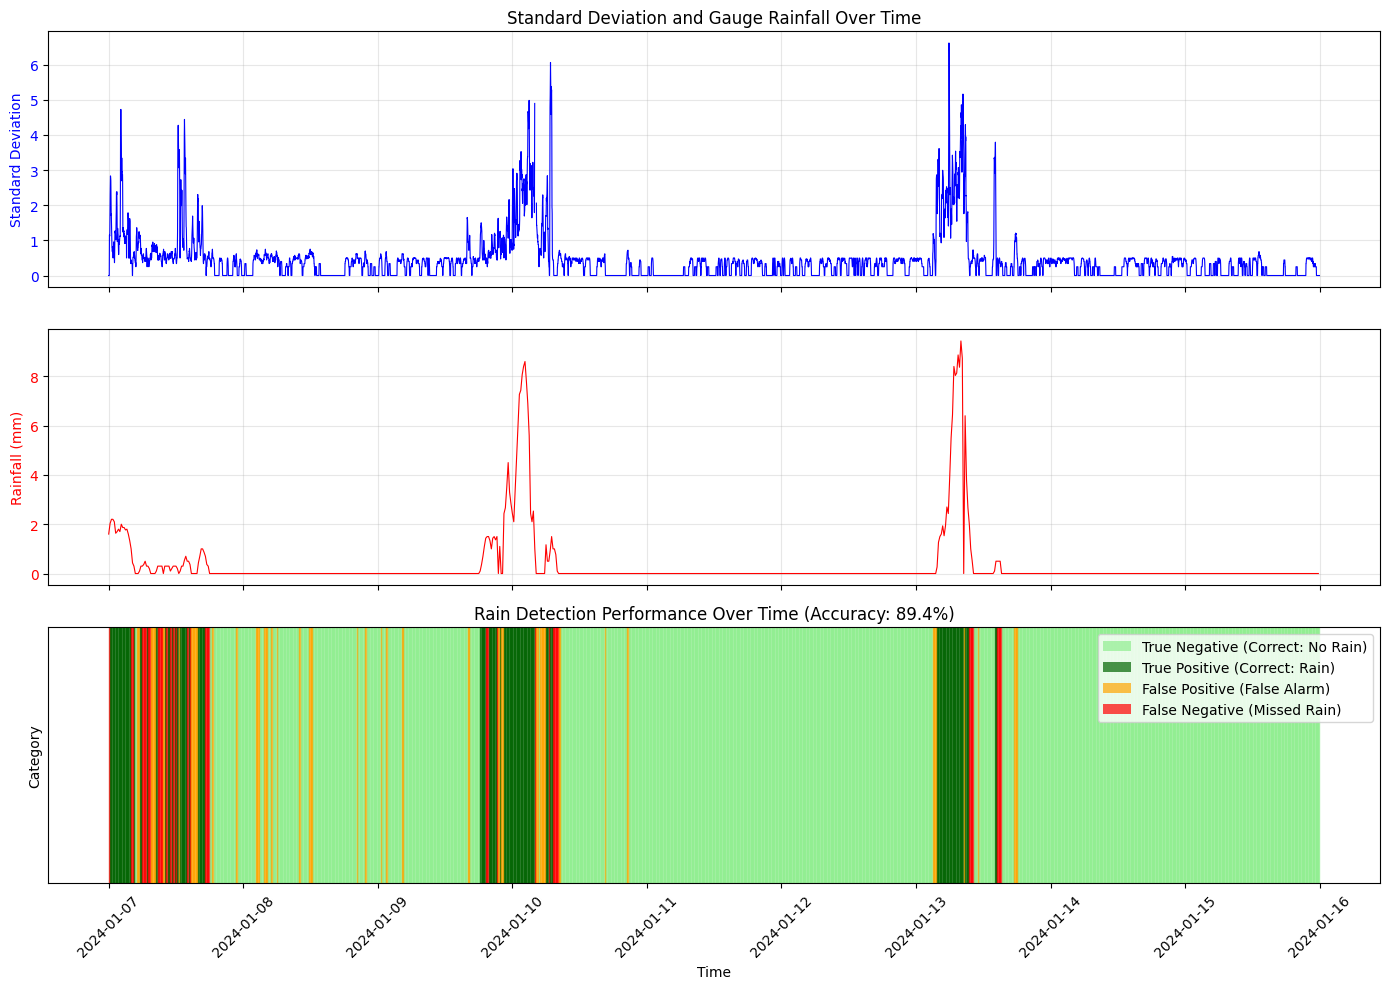

link frequency: 68.04


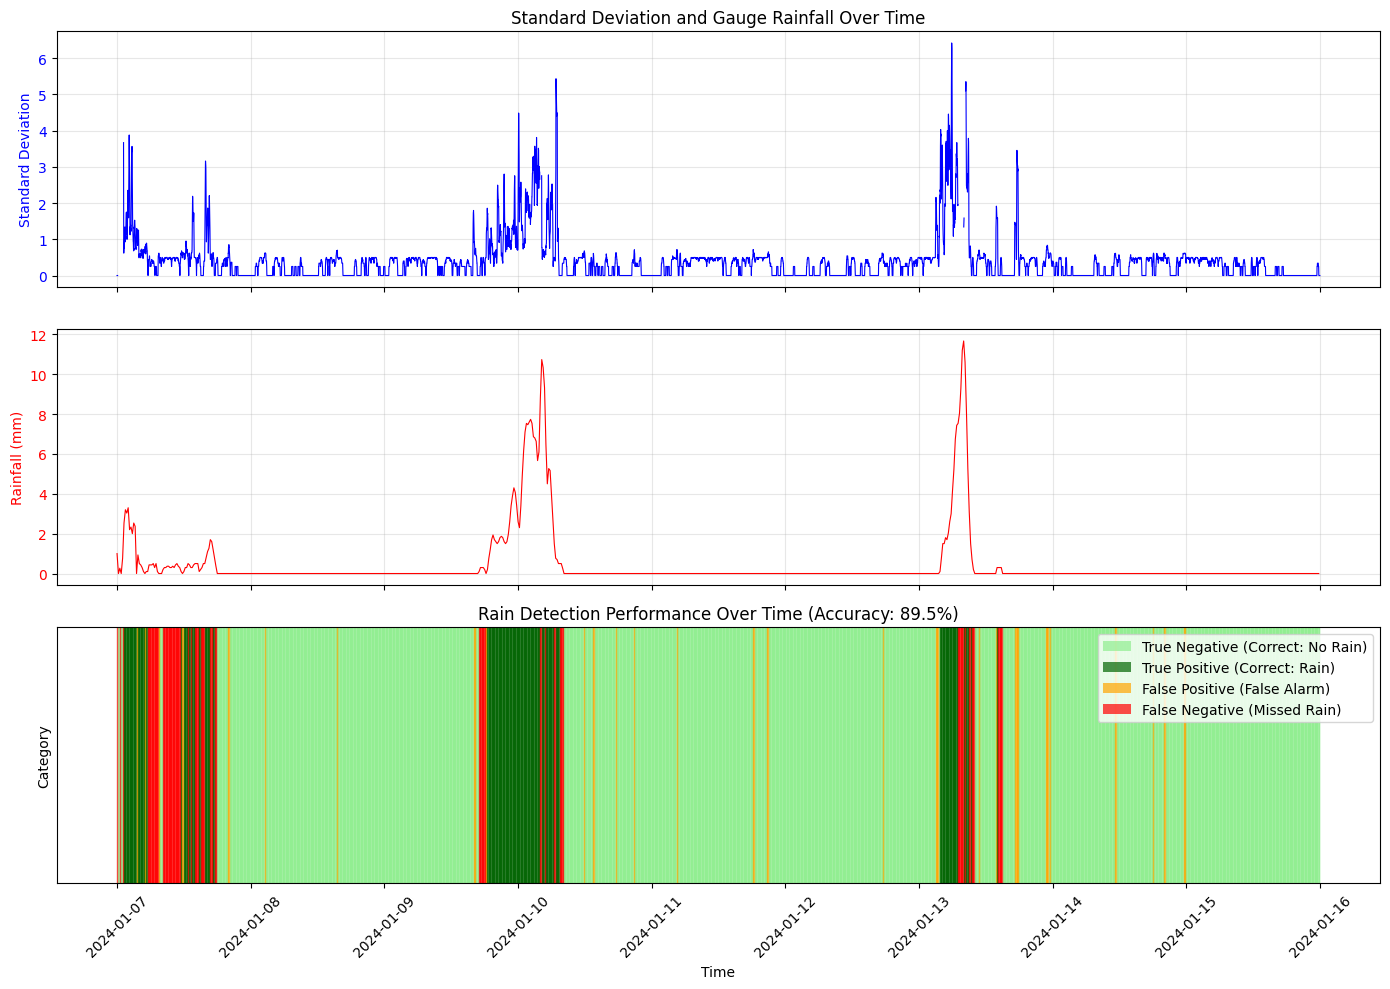

link frequency: 68.04


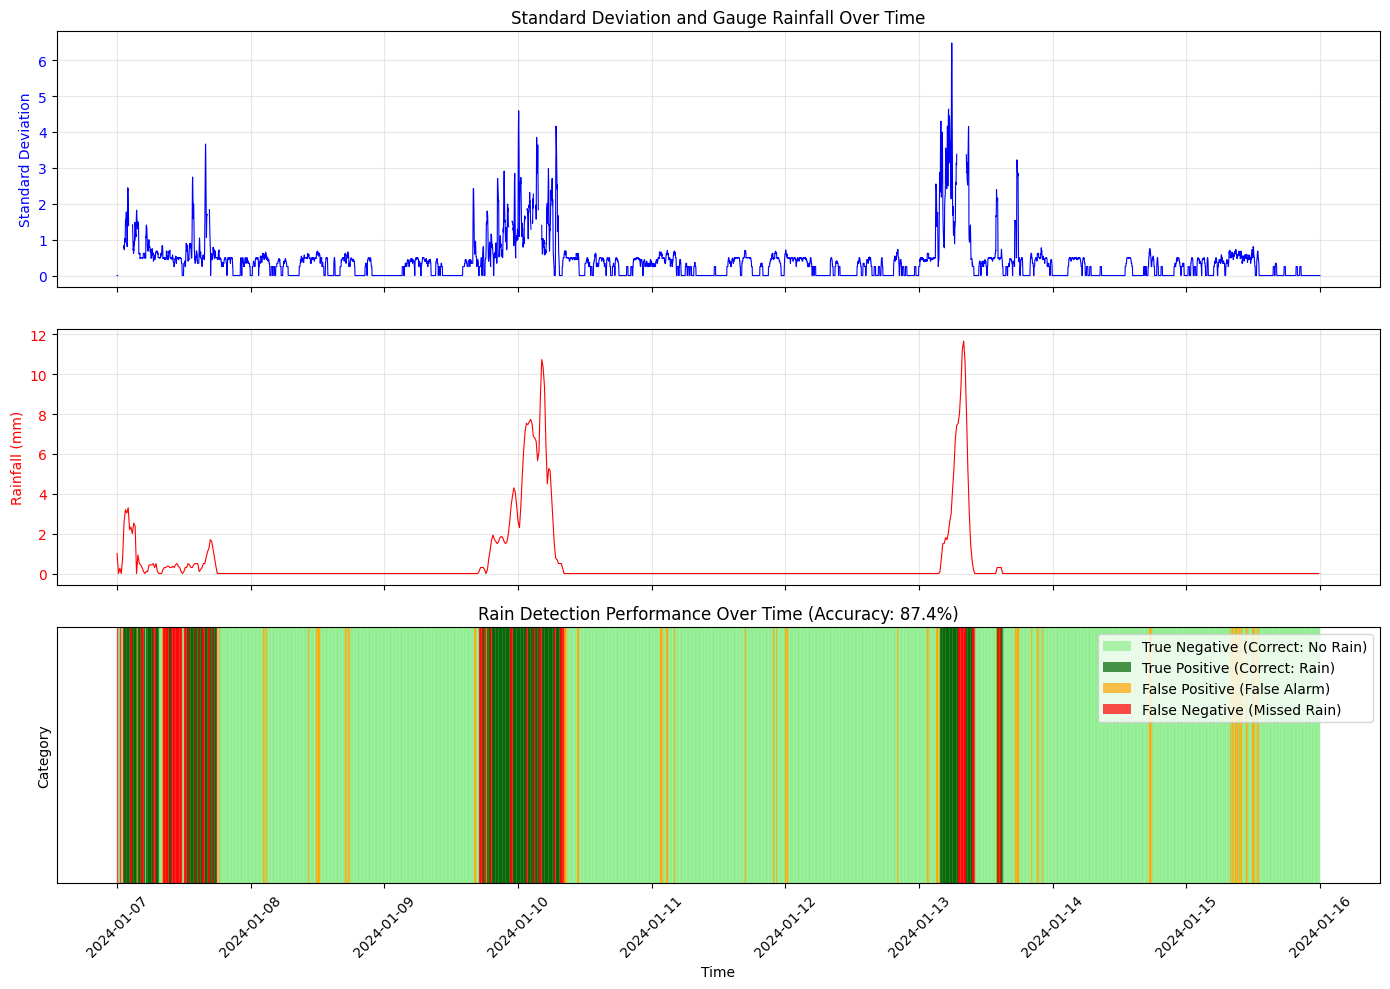

link frequency: 68.04


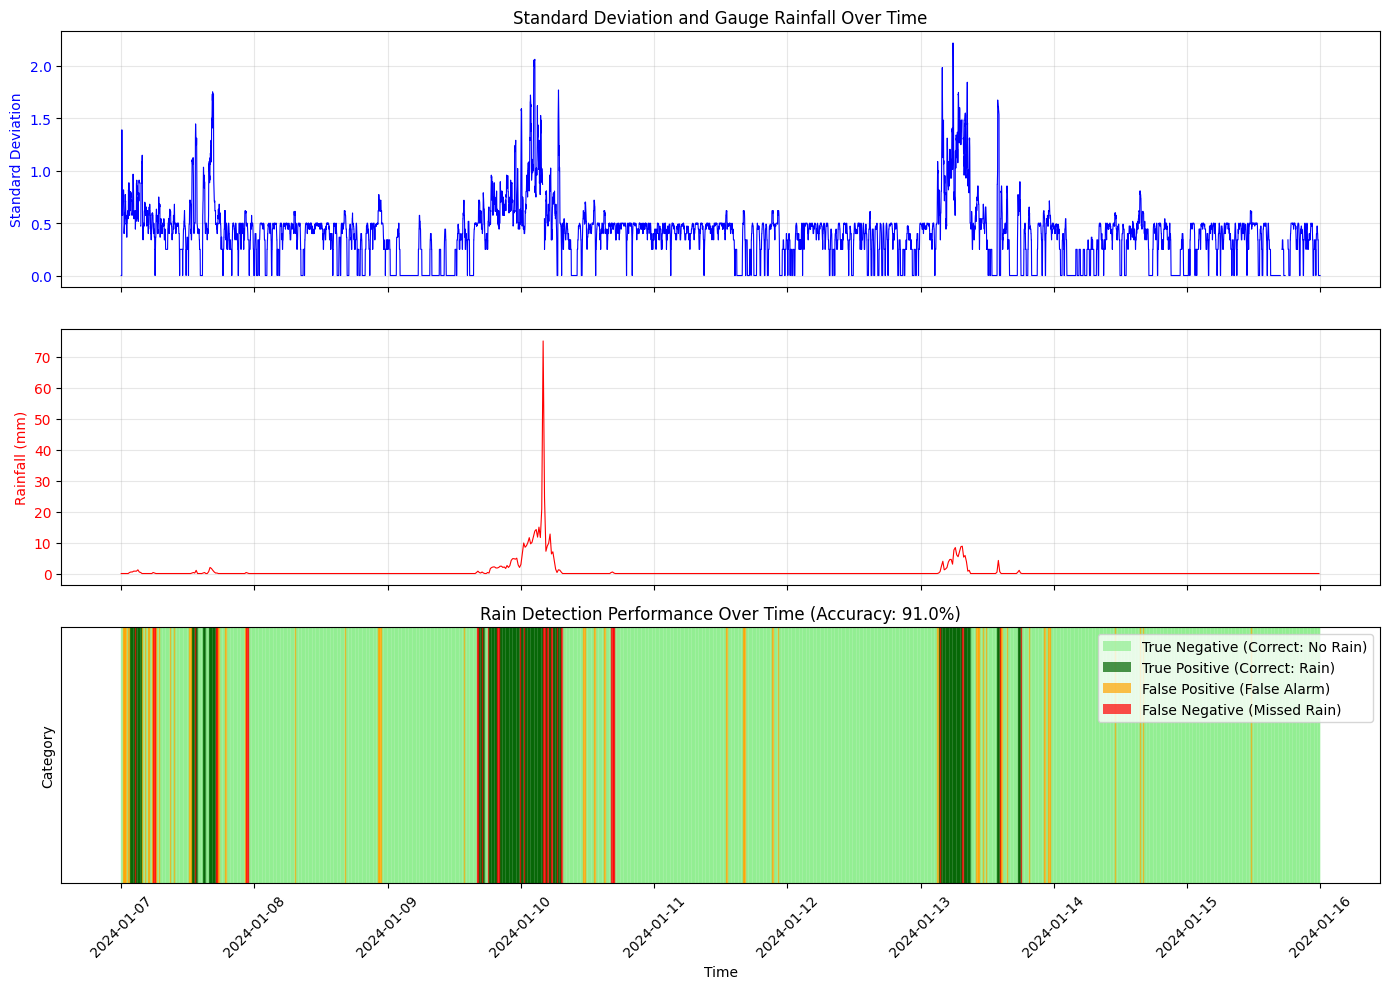

link frequency: 69.12


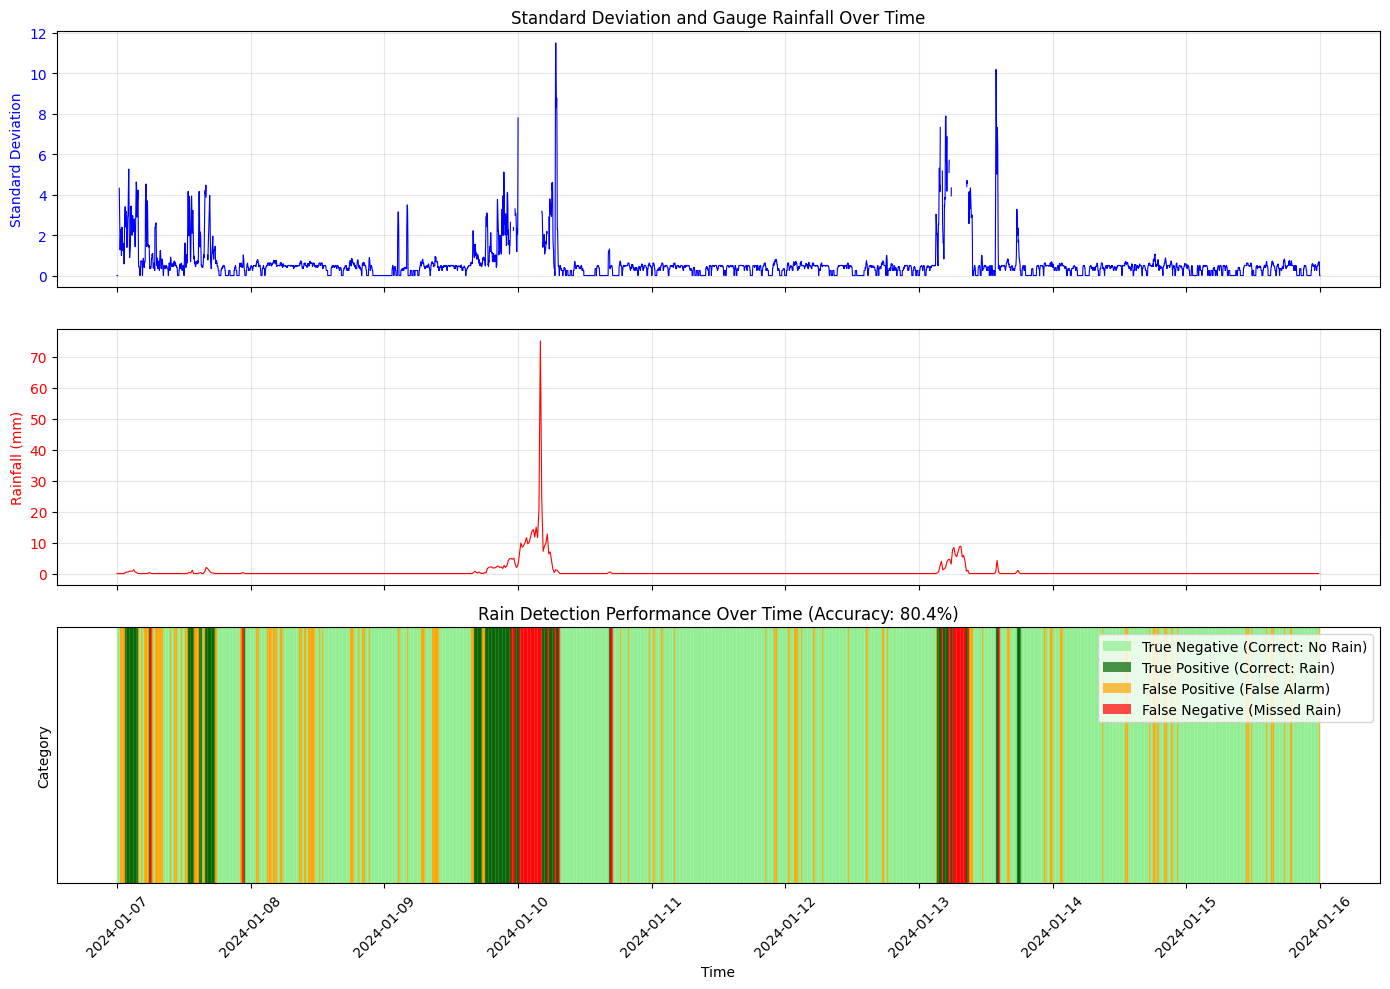

link frequency: 69.12


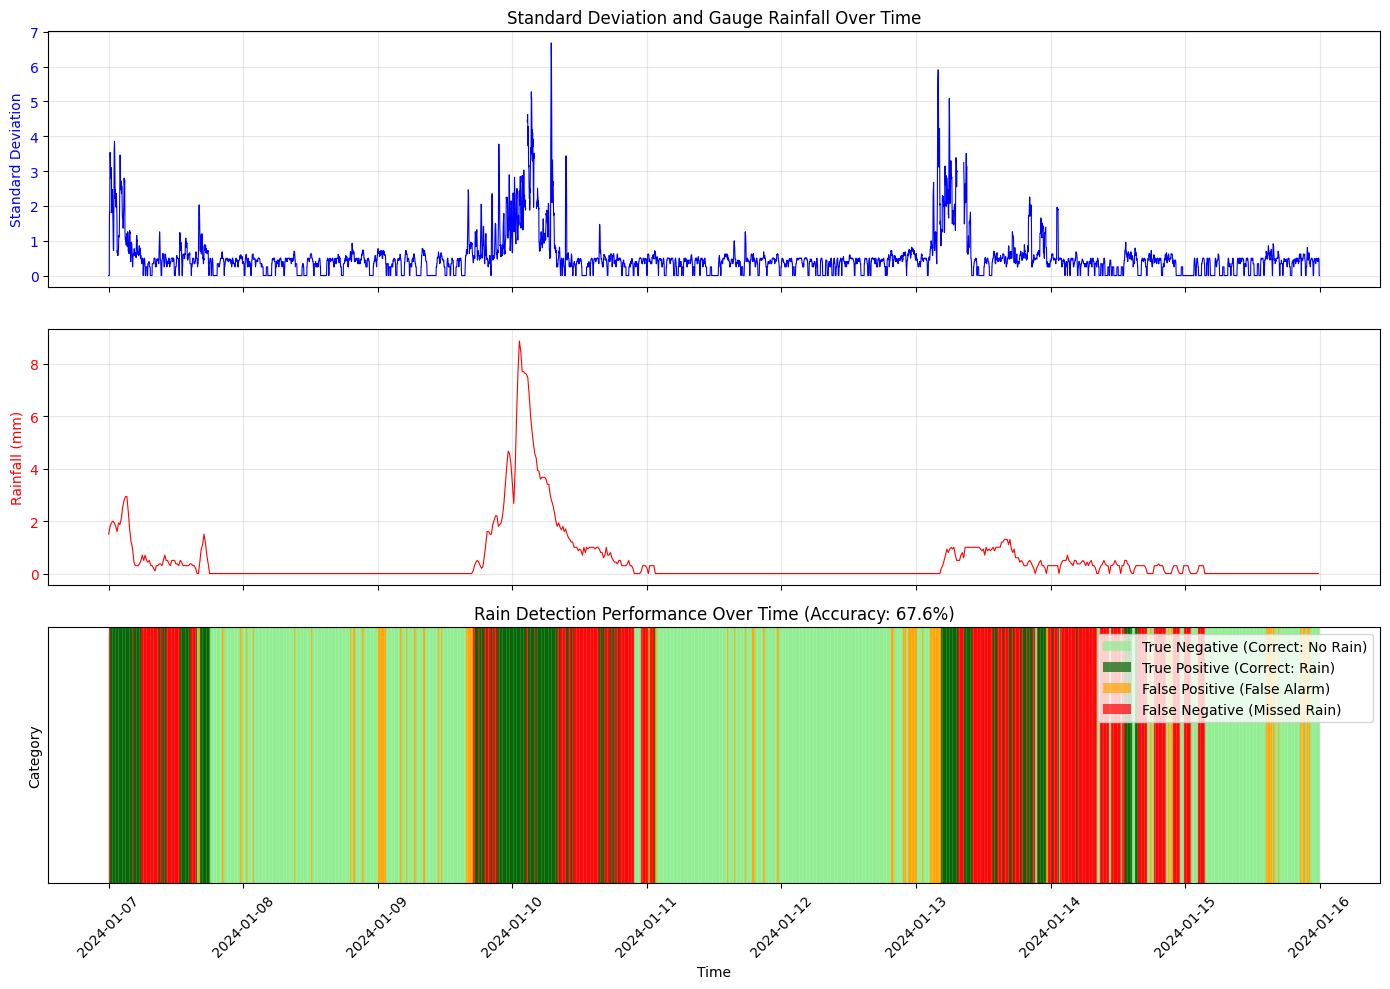

link frequency: 68.04


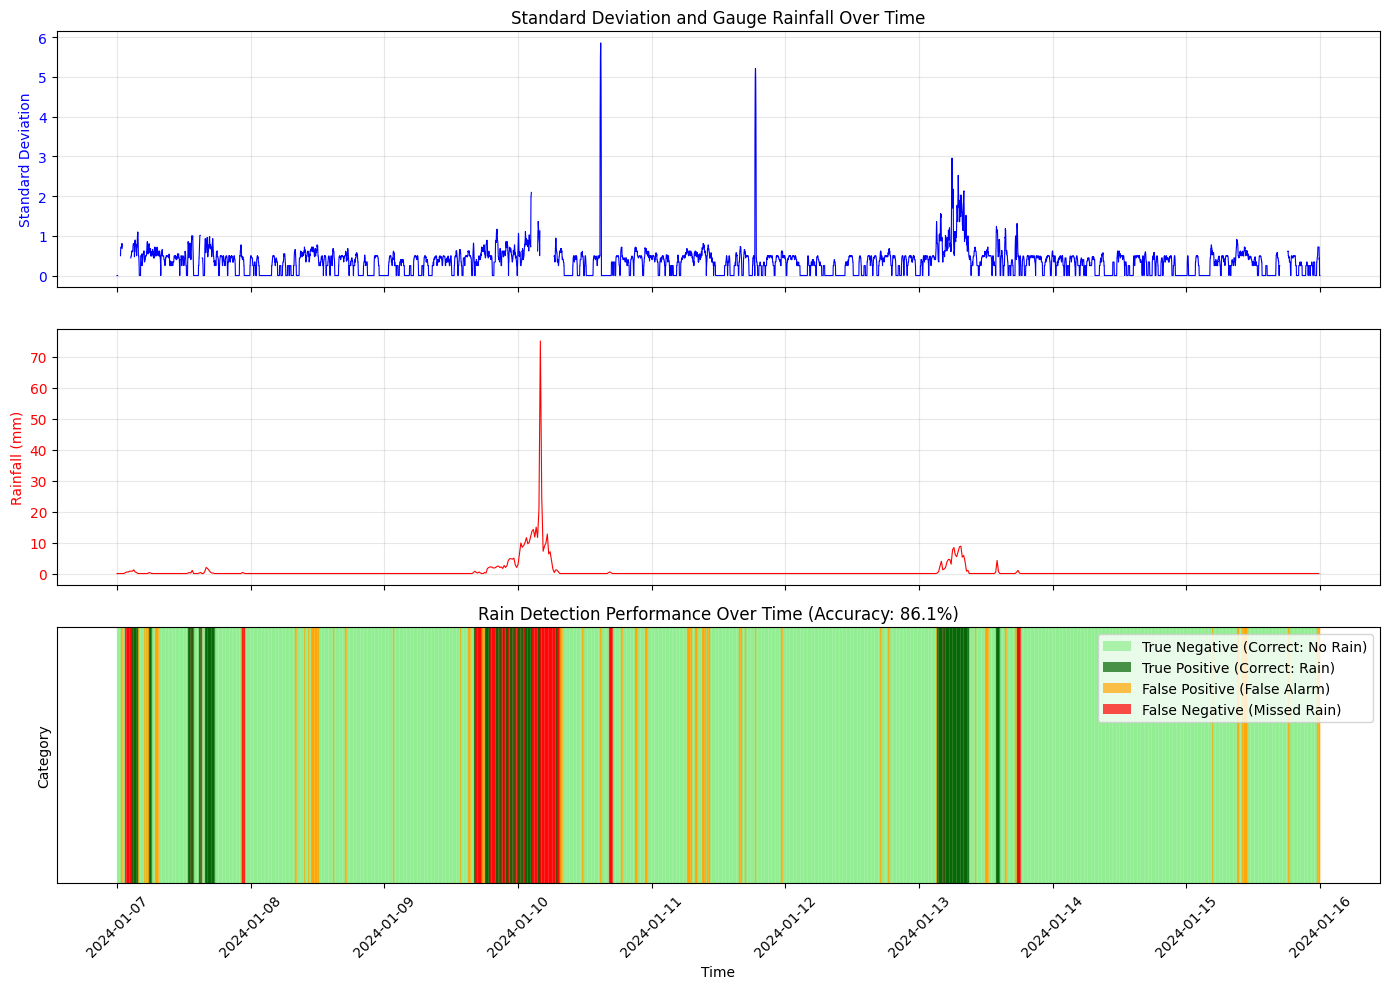

link frequency: 68.04


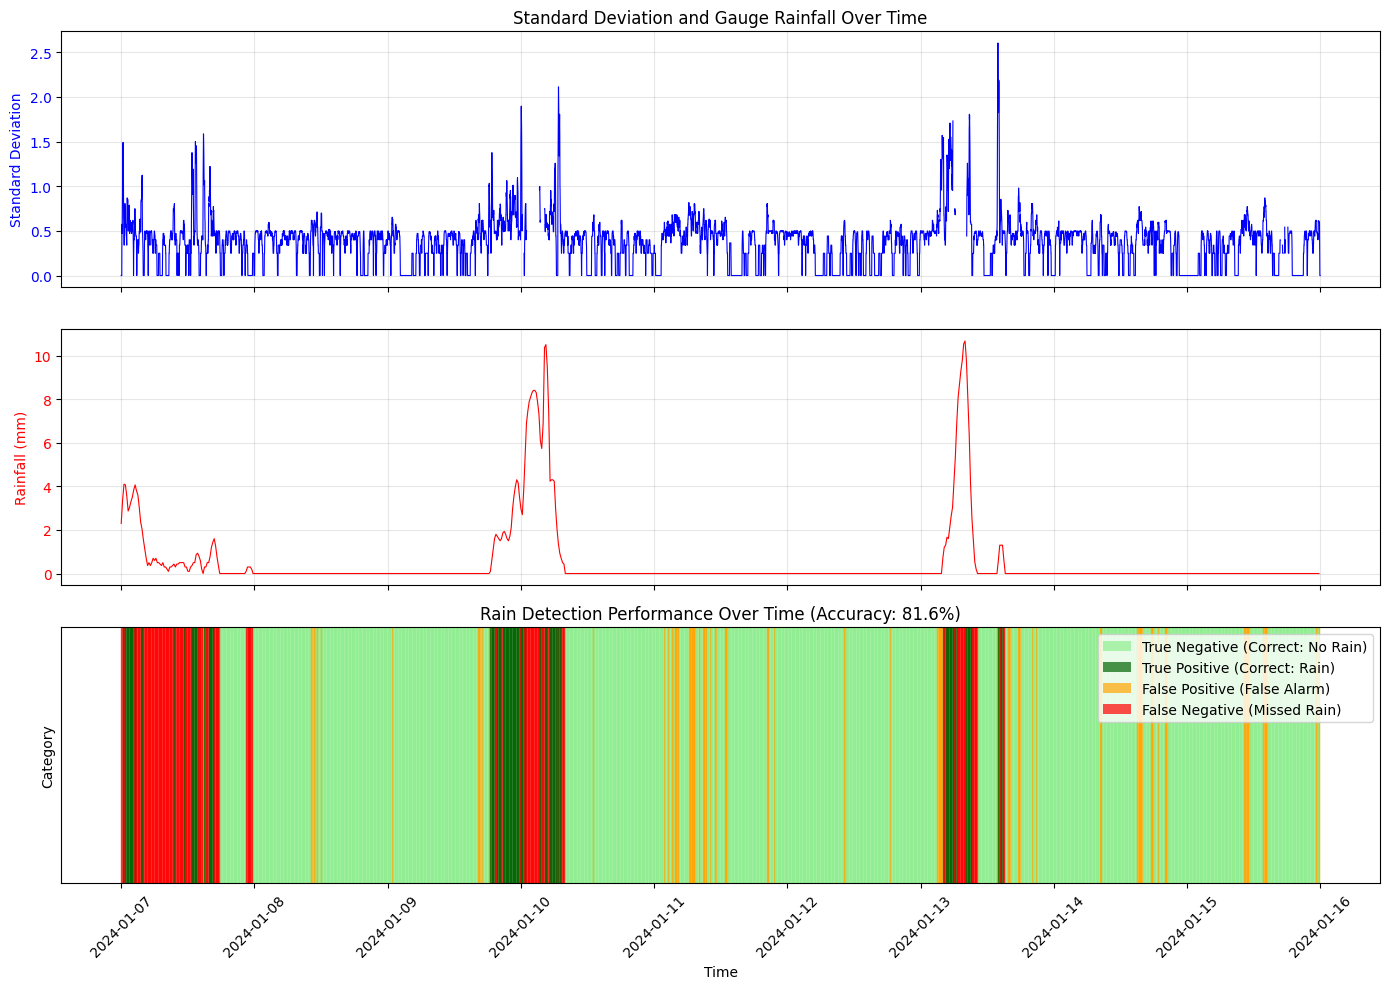

link frequency: 68.04


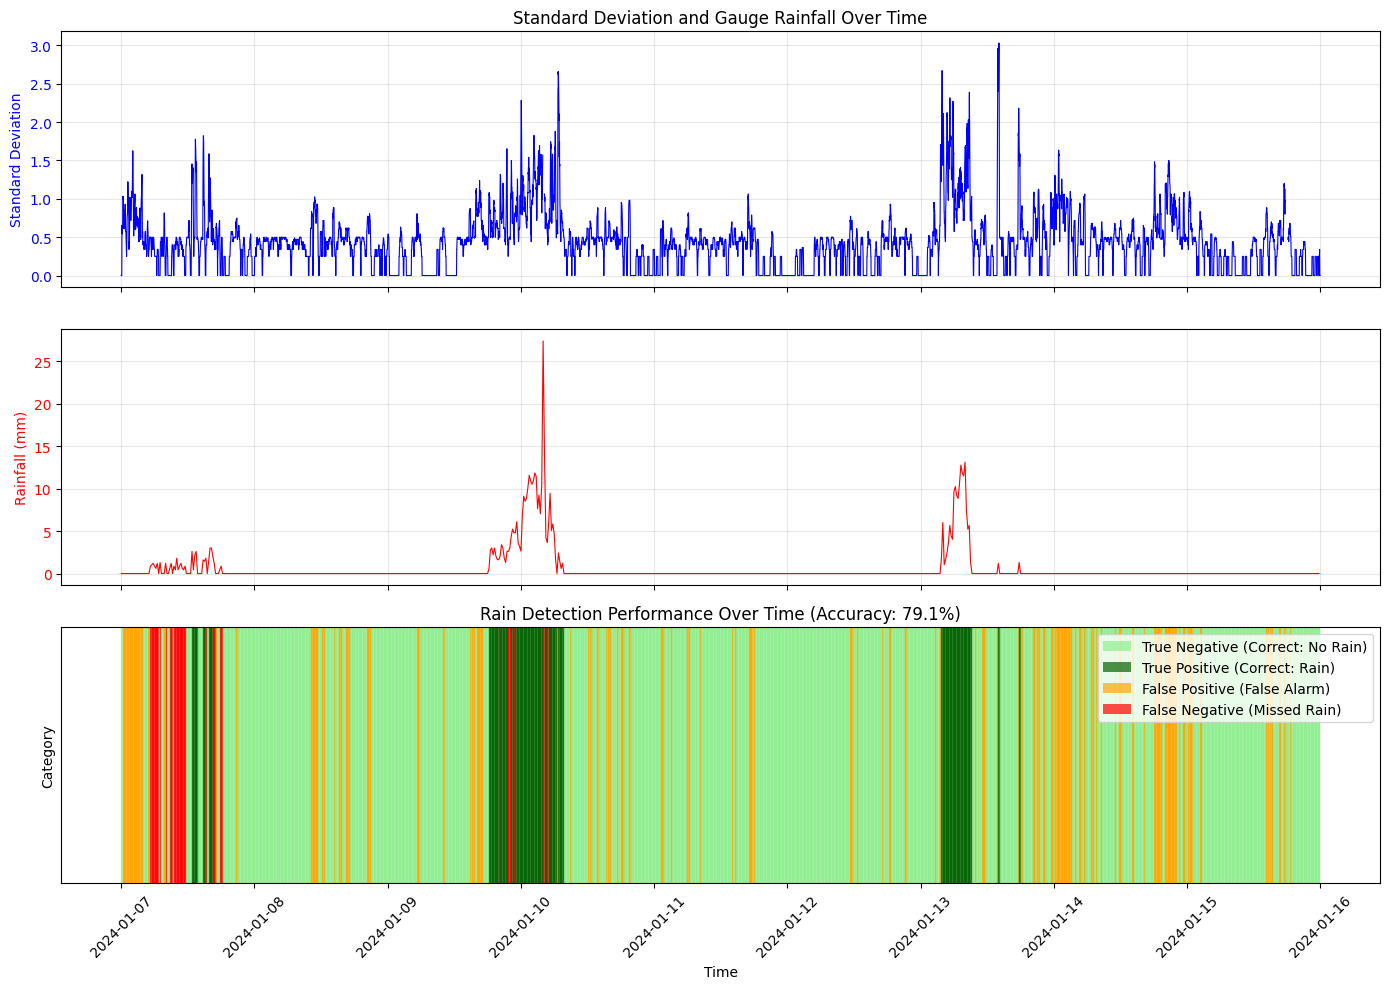

link frequency: 68.04


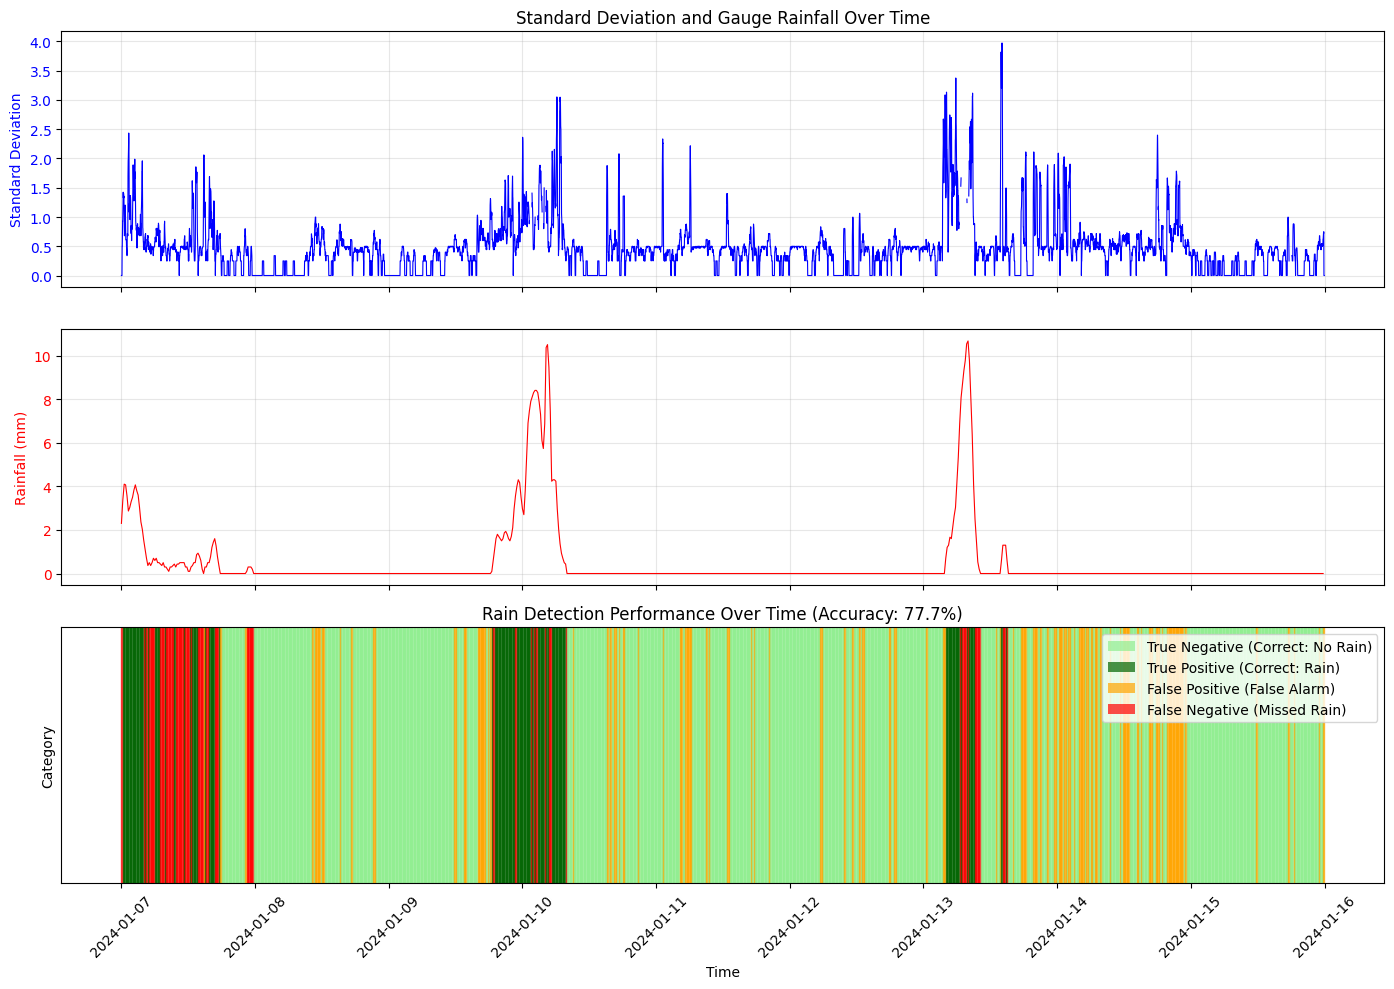

link frequency: 68.04


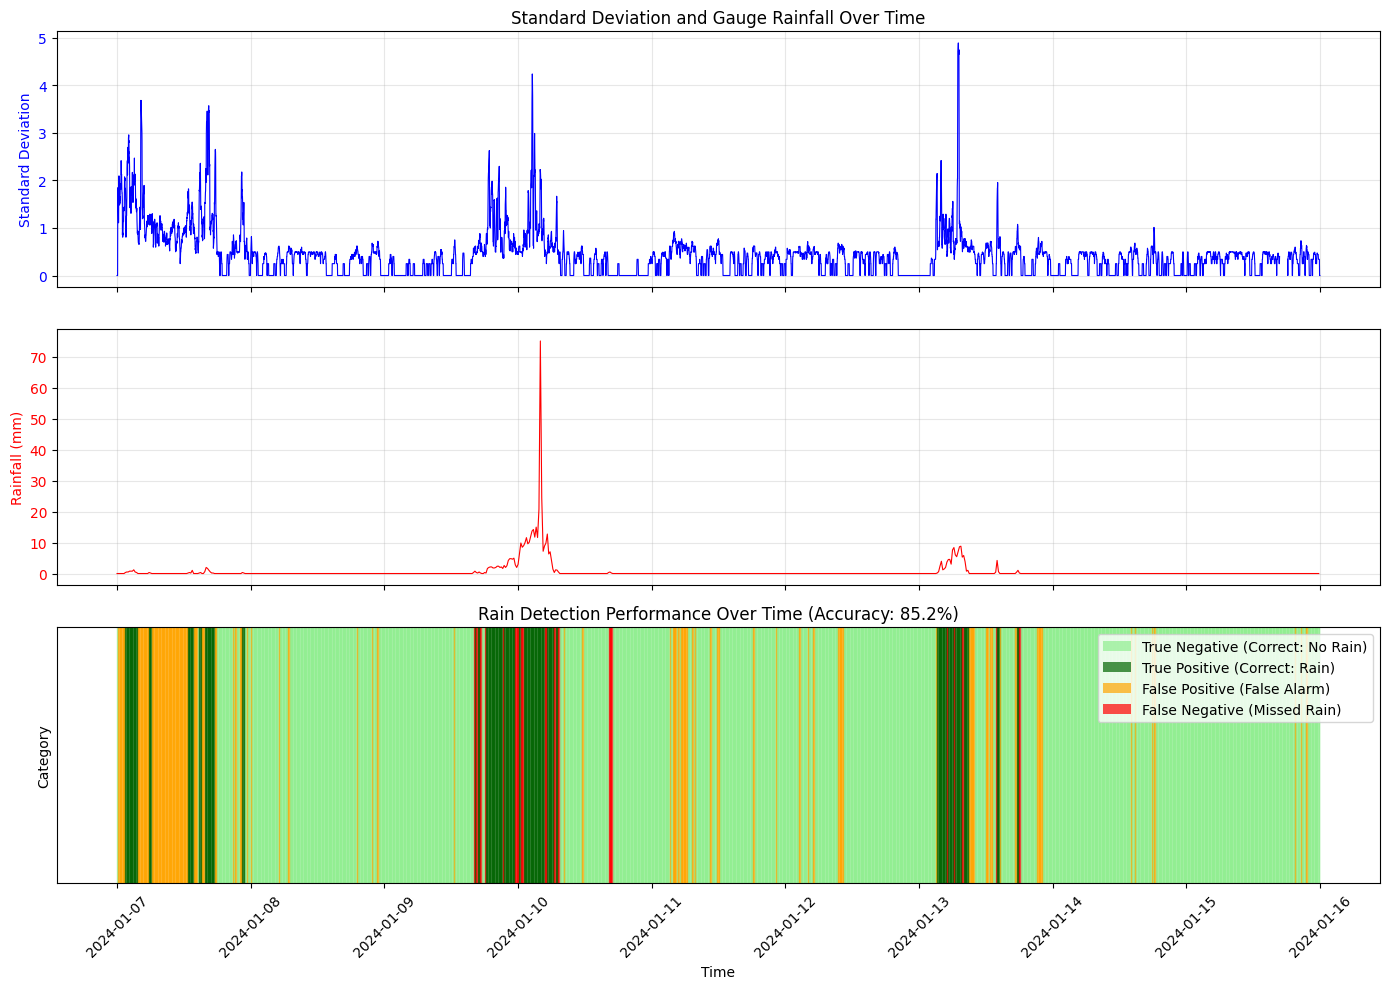

link frequency: 68.04


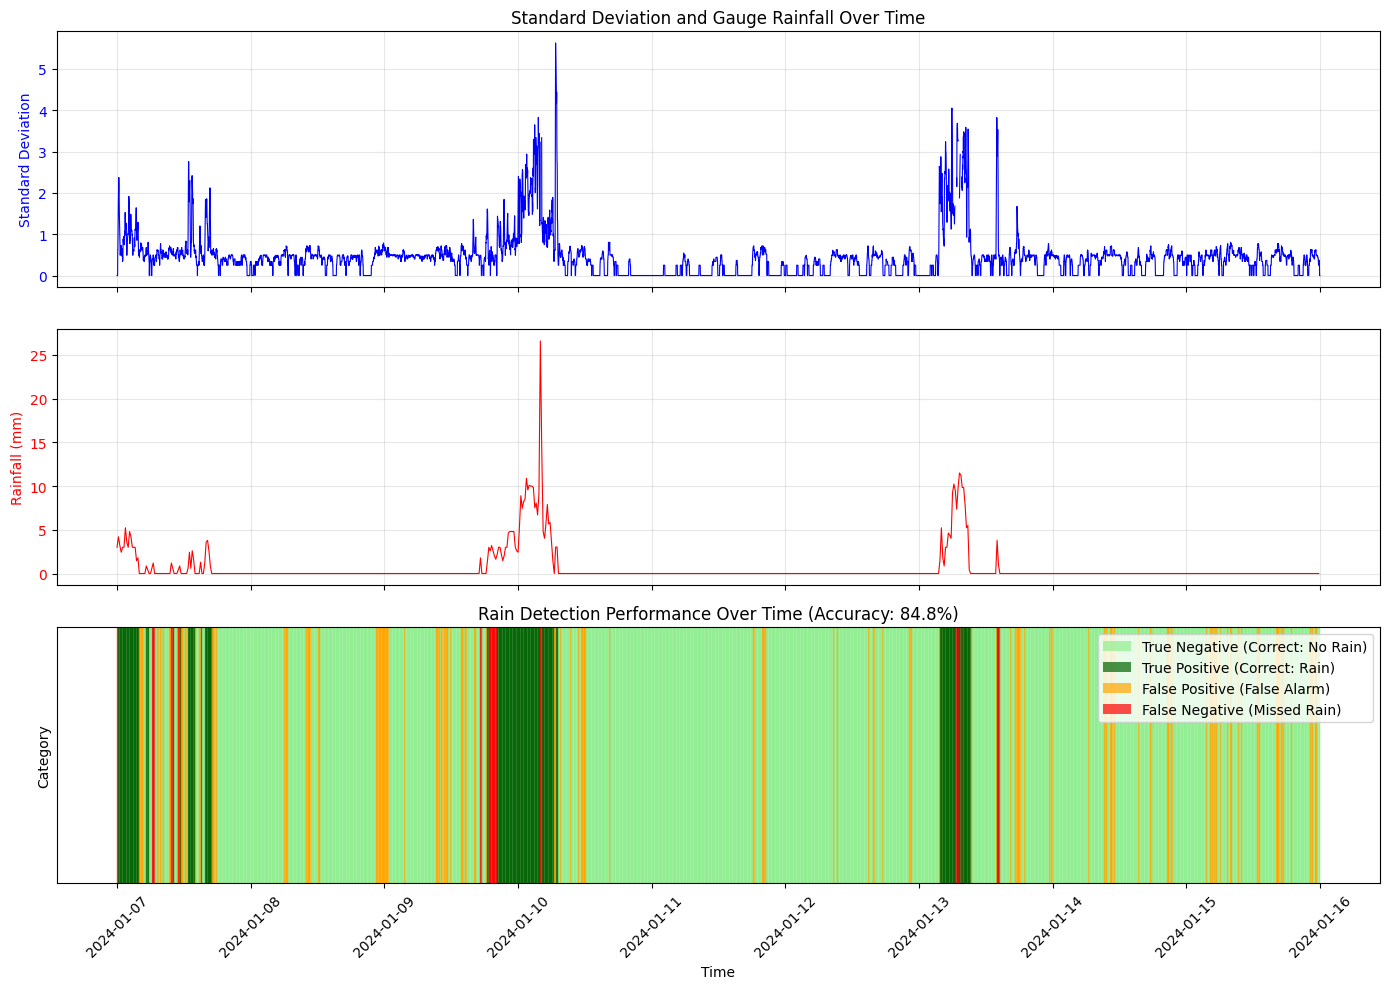

link frequency: 68.04


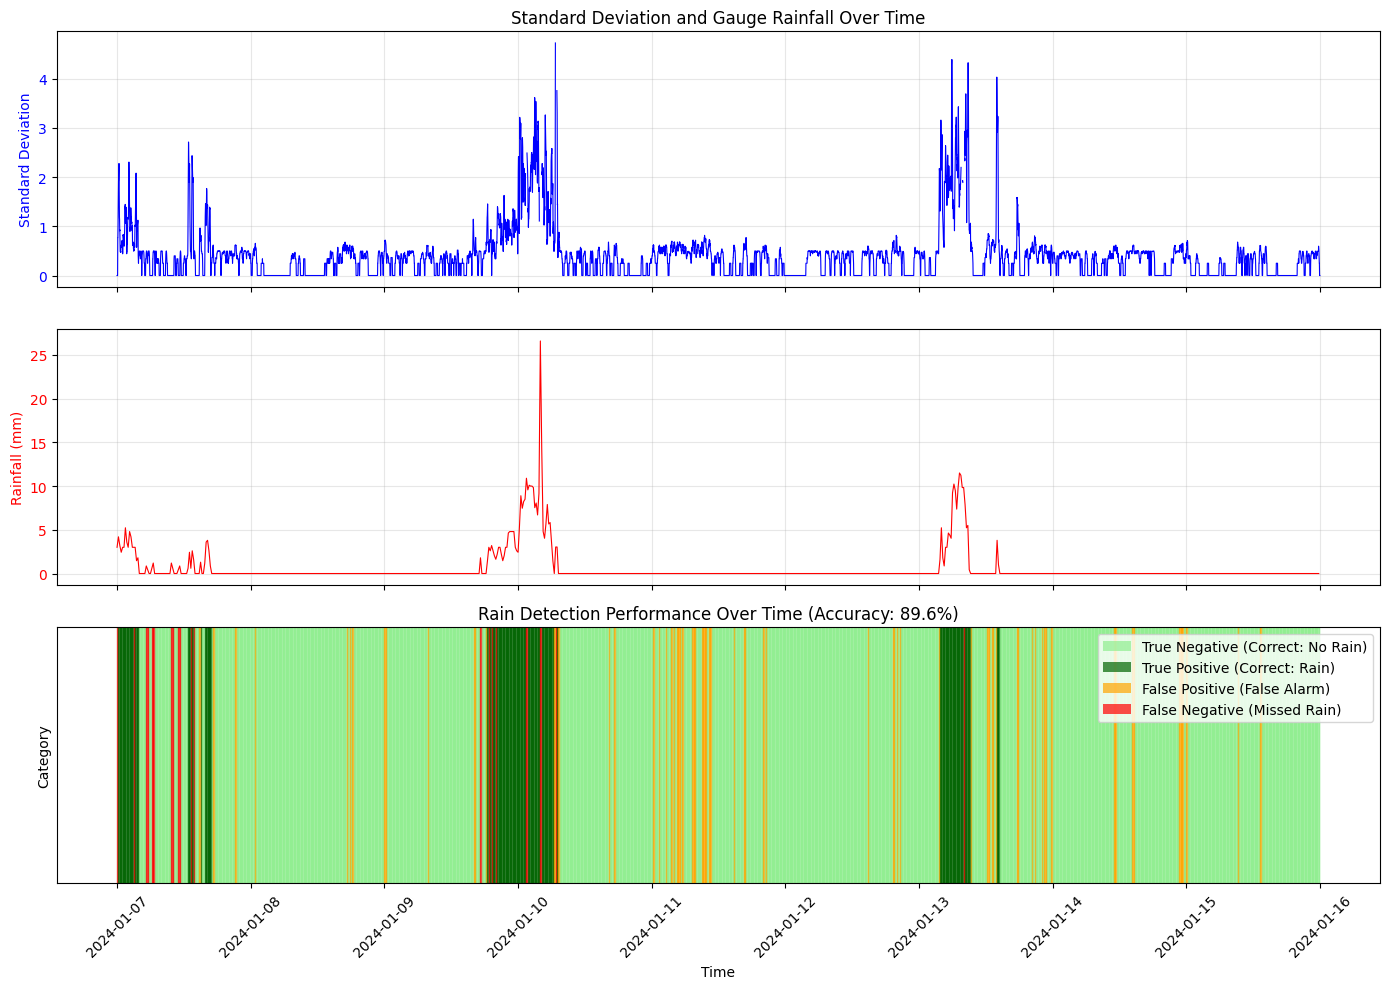

link frequency: 68.04


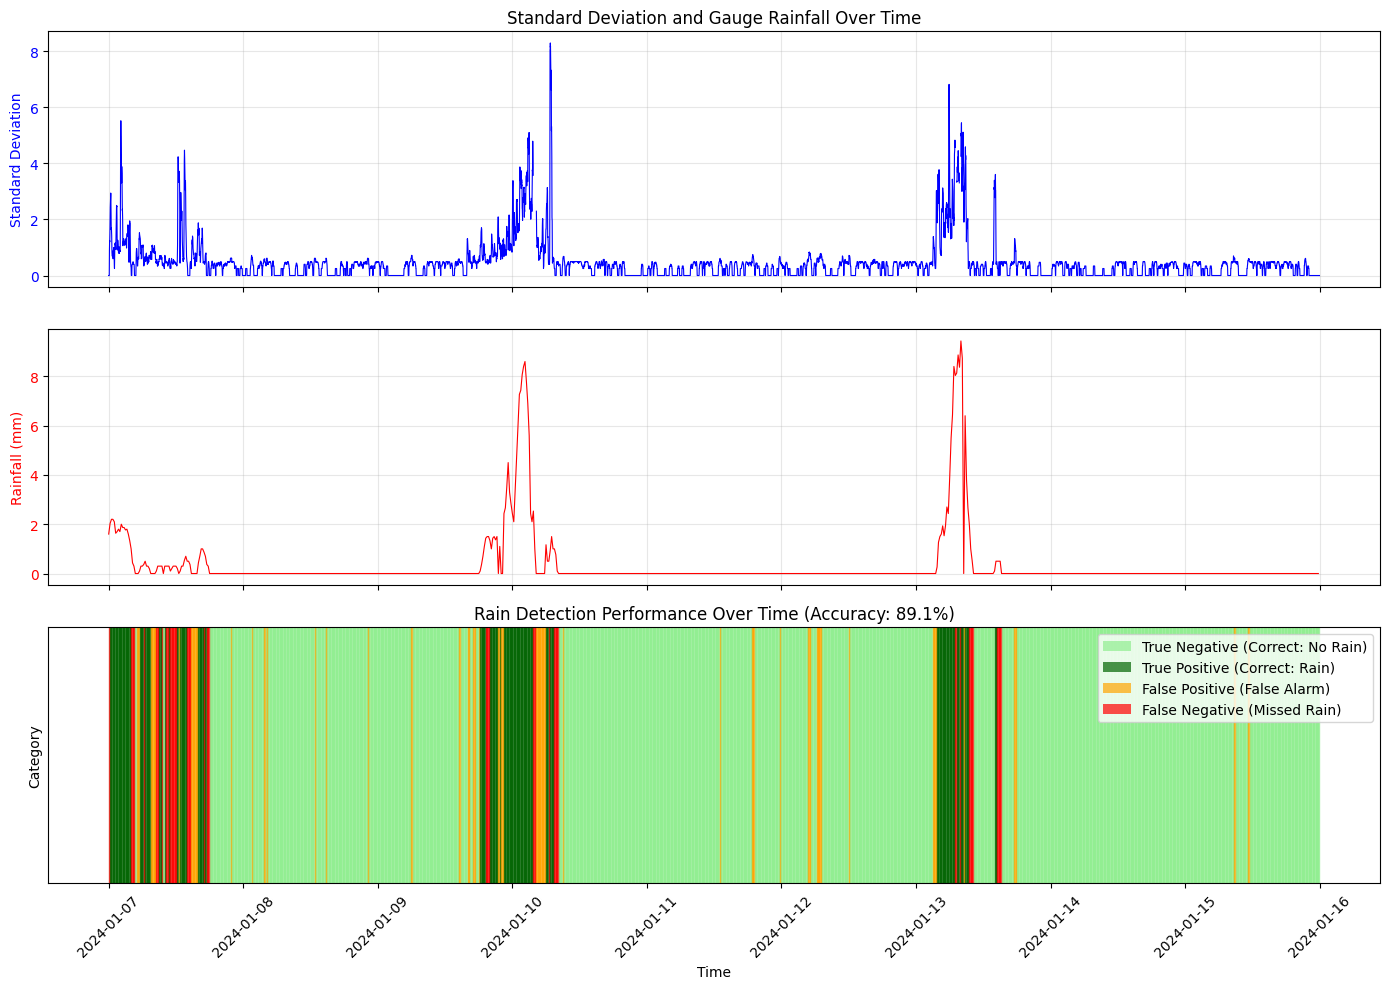

link frequency: 68.04


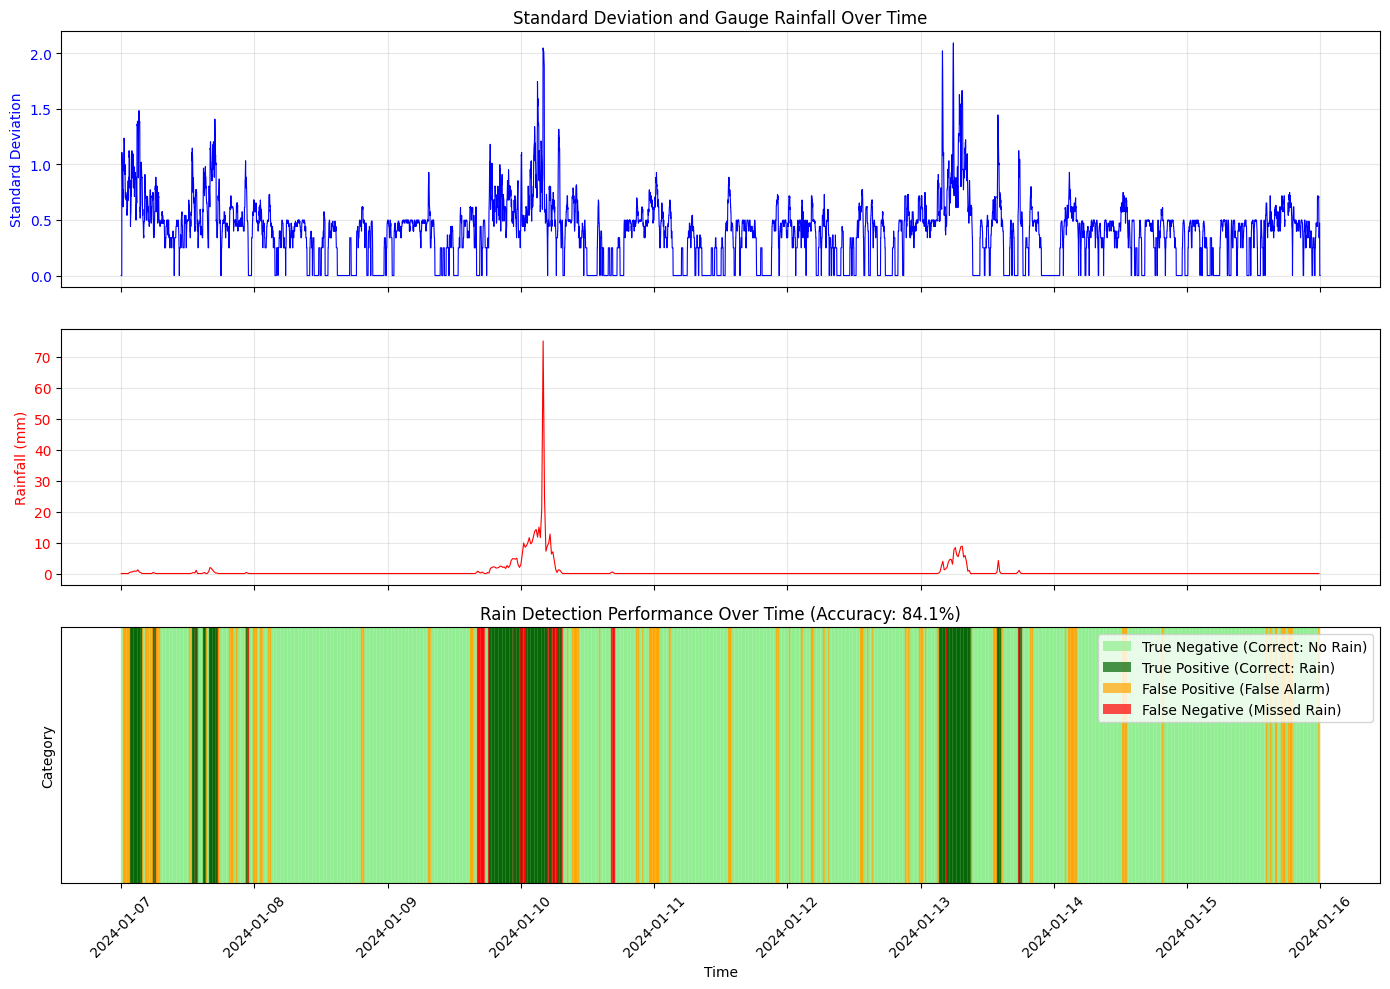

link frequency: 68.04


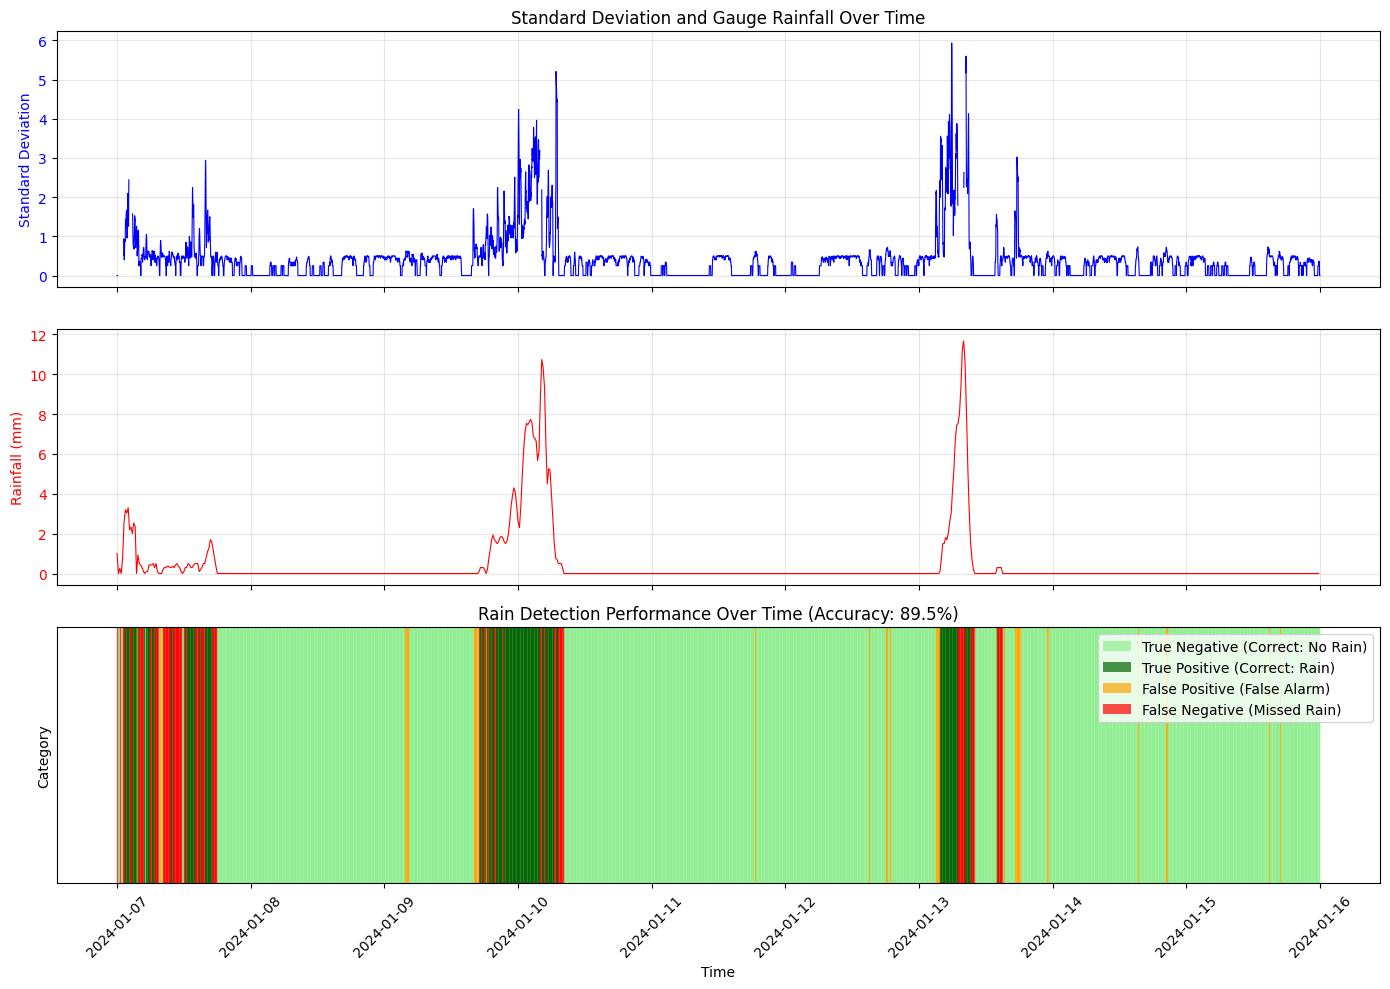

In [ ]:
for i in highfreqID:
    print(f'link frequency: {link_set_short.get_link(i).meta_data.frequency}')
    rain_detection(link_set.get_link(i), 0.59, 15, True, False)

Between 22/03/2024 and 30/03/2024 (9 days)

In [503]:
ds_short2 = ds.sel(time=slice('2024-03-22', '2024-03-30'))
link_set_short2 = patched_xarray2link_with_gauges(ds_short2, ps, max_distance=5000)

Processing sublinks: 100%|██████████| 3/3 [00:00<00:00,  5.10it/s]


Processing Summary:
  ✅ Valid links created: 100
  ⚠️  Skipped (missing coordinates): 122
  ⚠️  Skipped (no RSL data): 3
  📊 Total processed: 225



In [508]:
highfreq2 = [
    link
    for link in link_set_short.link_list
    if link.meta_data.frequency > 68.0
]

highfreqID2 = []
for i in range(0,len(link_set_short2)):
    if link_set_short2.get_link(i).meta_data.frequency >= 68:
        highfreqID2.append(i)

Overlap period: 2024-03-22T00:00:00 to 2024-03-30T23:59:00
Link WD data points: 12958
Gauge data points: 2592
Interpolated detection length: 2592


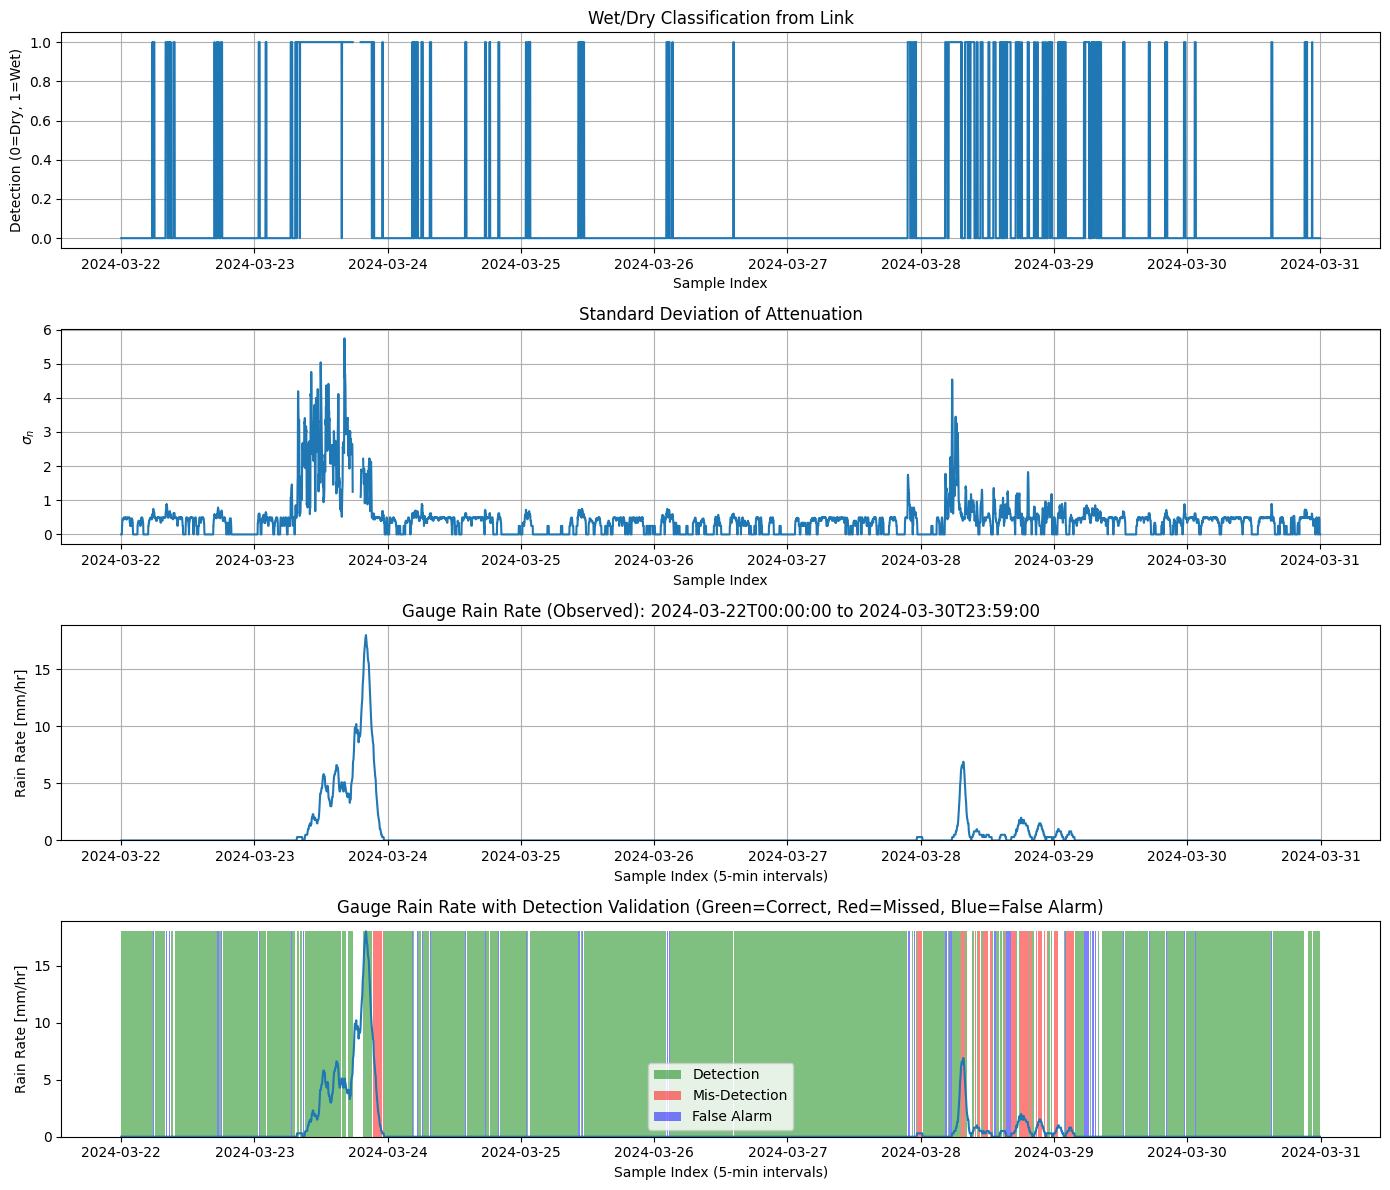


📊 Detection Performance:
  True Positives (correctly detected rain): 216
  True Negatives (correctly detected dry): 2002
  False Positives (false alarms): 174
  False Negatives (missed rain): 176
  Positive detection: 0.5510204081632653
  Negative detection: 0.9200367647058824
  Accuracy: 85.57%


In [505]:
classification_plot(link_set_short2.get_link(highfreqID2[1]),15,0.58)

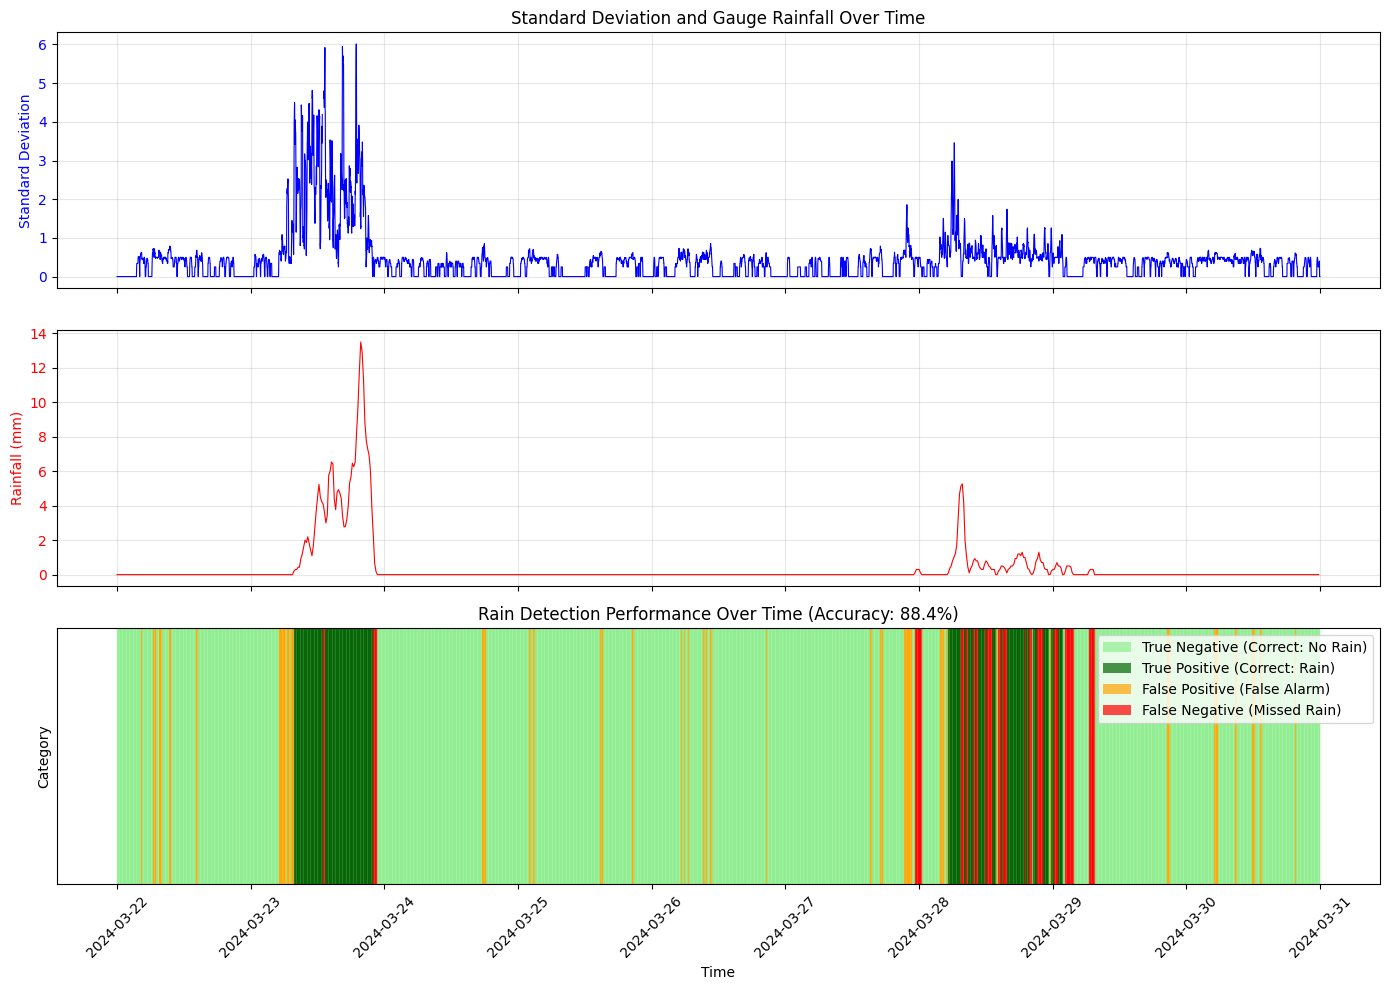

{'accuracy': 0.8842592592592593,
 'positive_acc': 0.7171052631578947,
 'negative_acc': 0.9199438202247191,
 'categories': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0,
        0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [506]:
rain_detection(link_set_short2.get_link(highfreqID2[0]), 0.59, 15, True, False)

### Detection for every high-frequency sublink between 07/01 and 16/01
### std threshold = 0.62

link frequency: 68.04


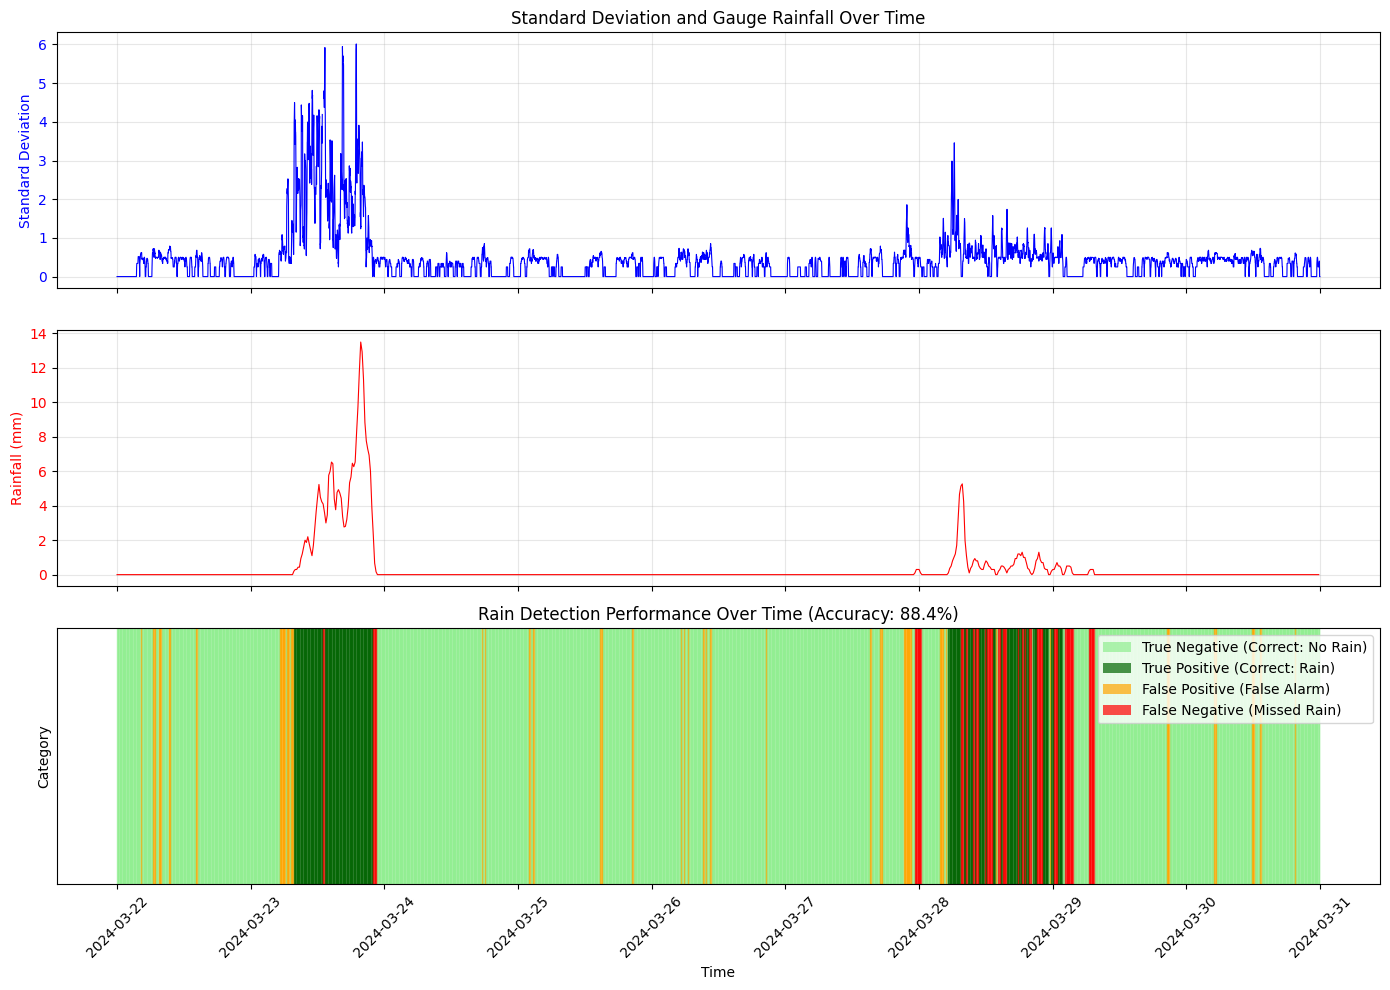

link frequency: 68.04


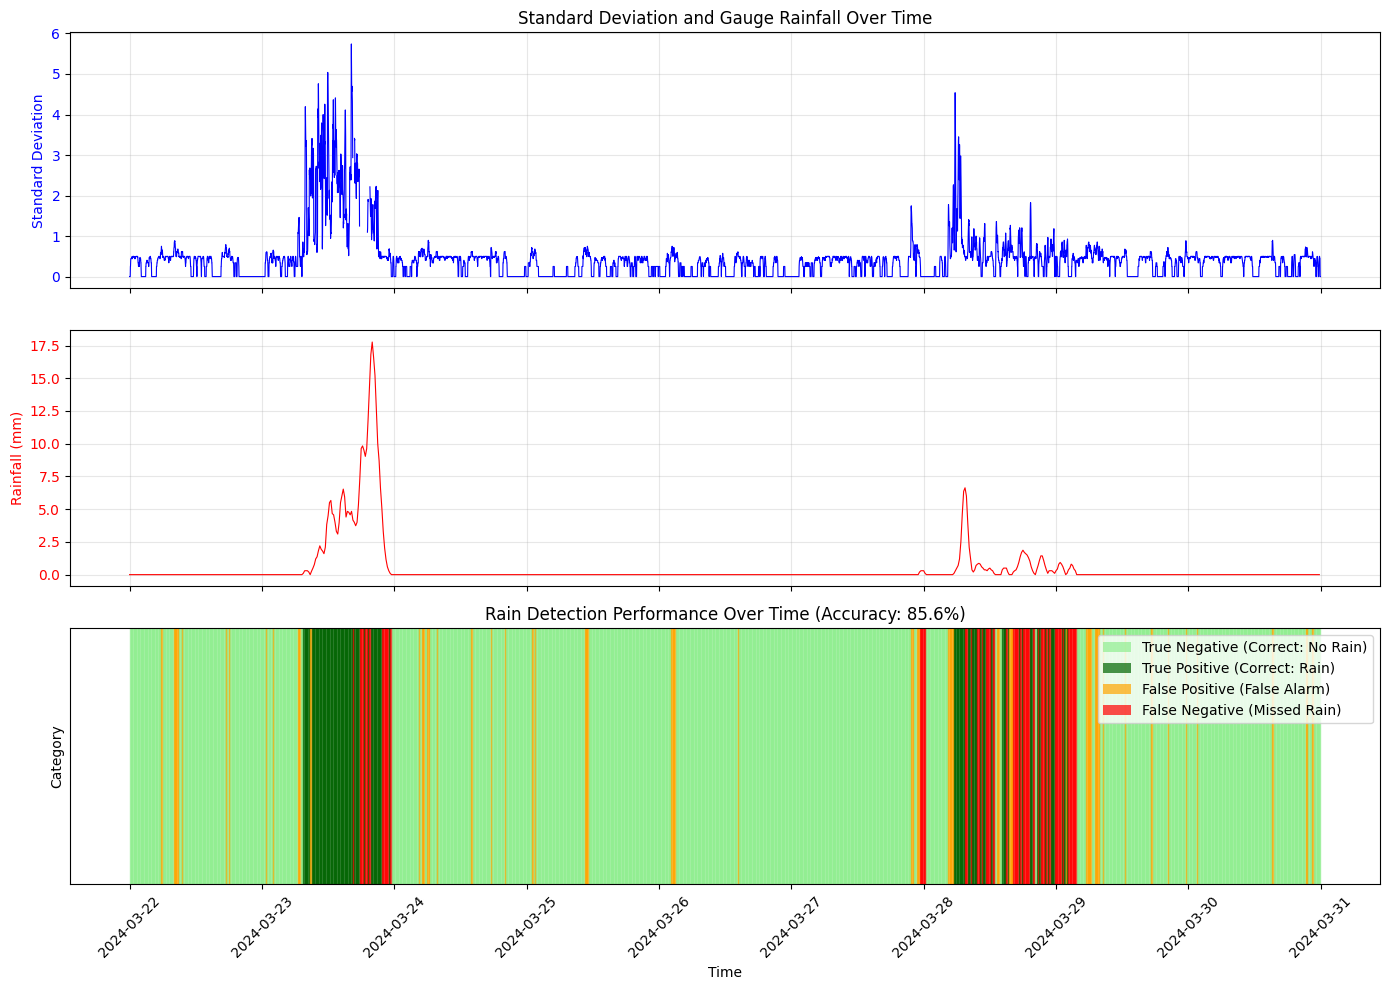

link frequency: 68.04


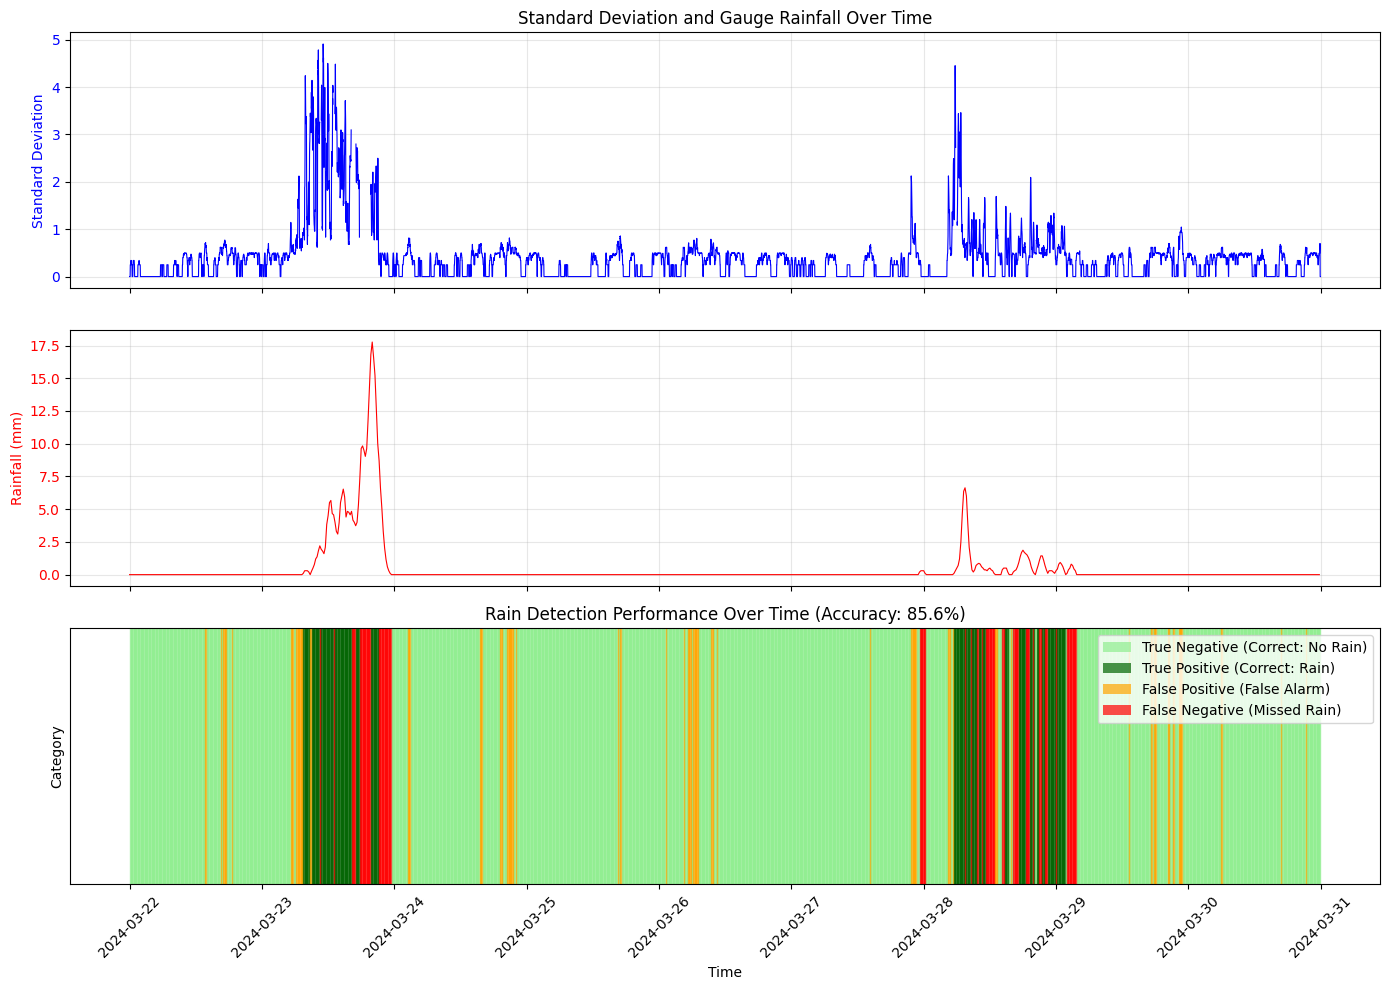

link frequency: 68.04


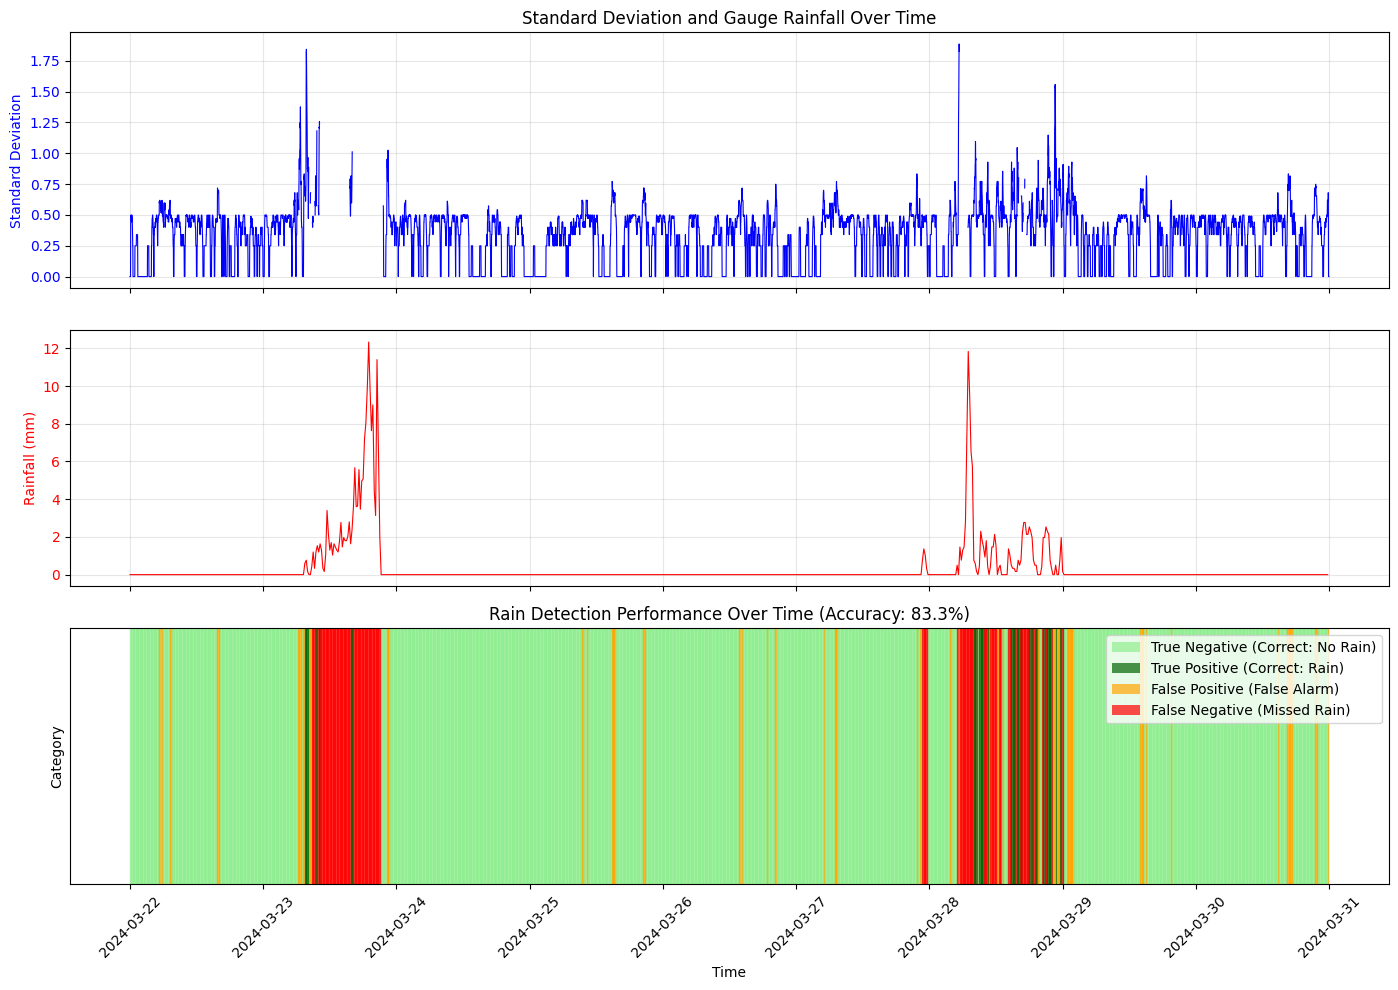

link frequency: 69.12


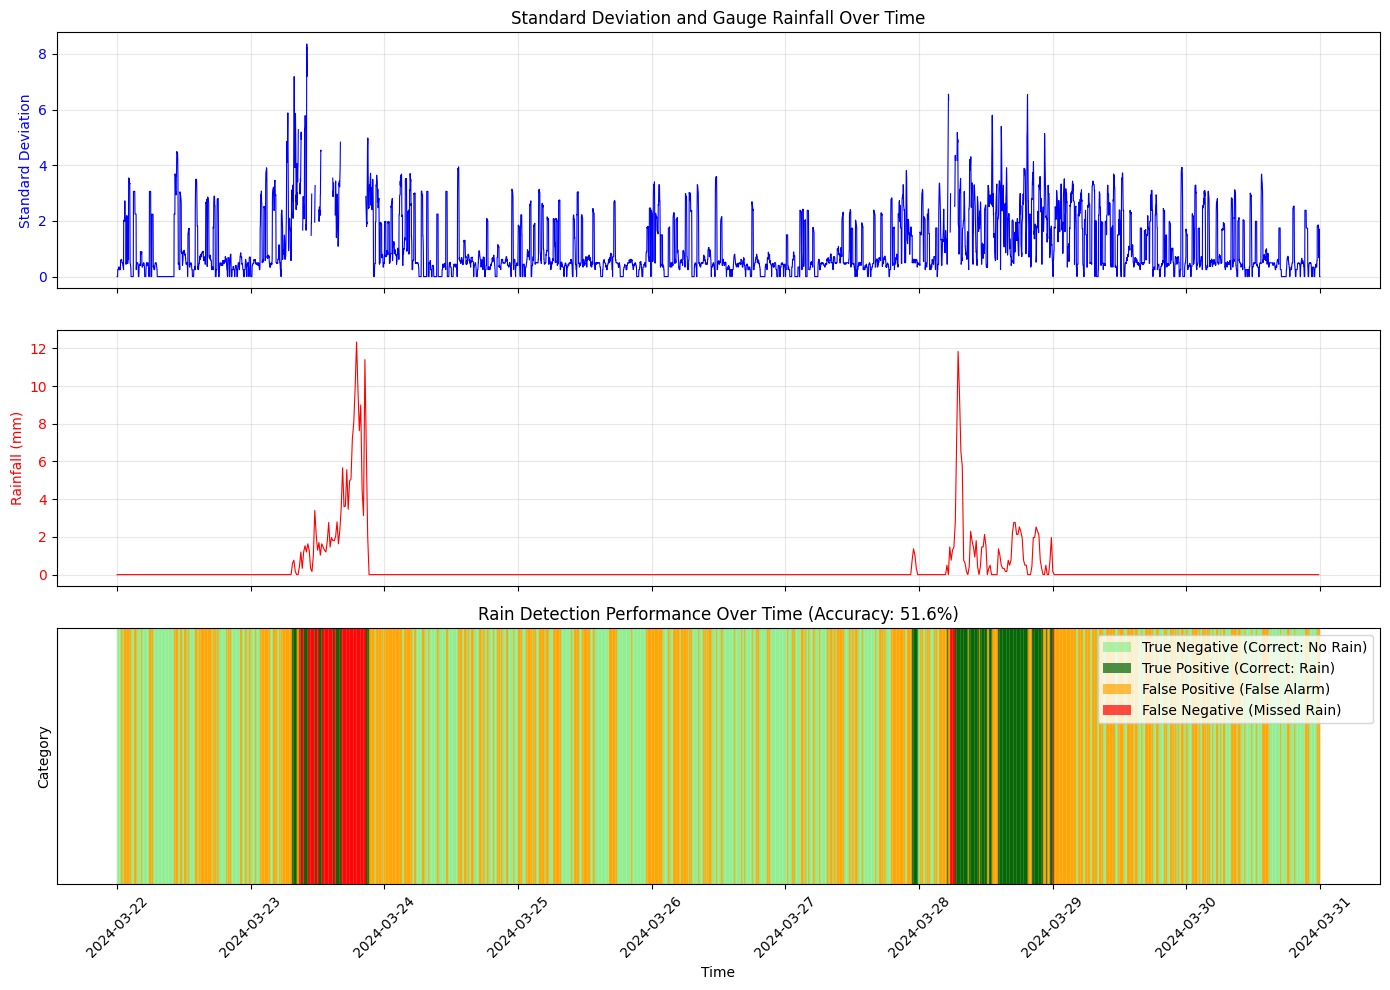

link frequency: 69.12


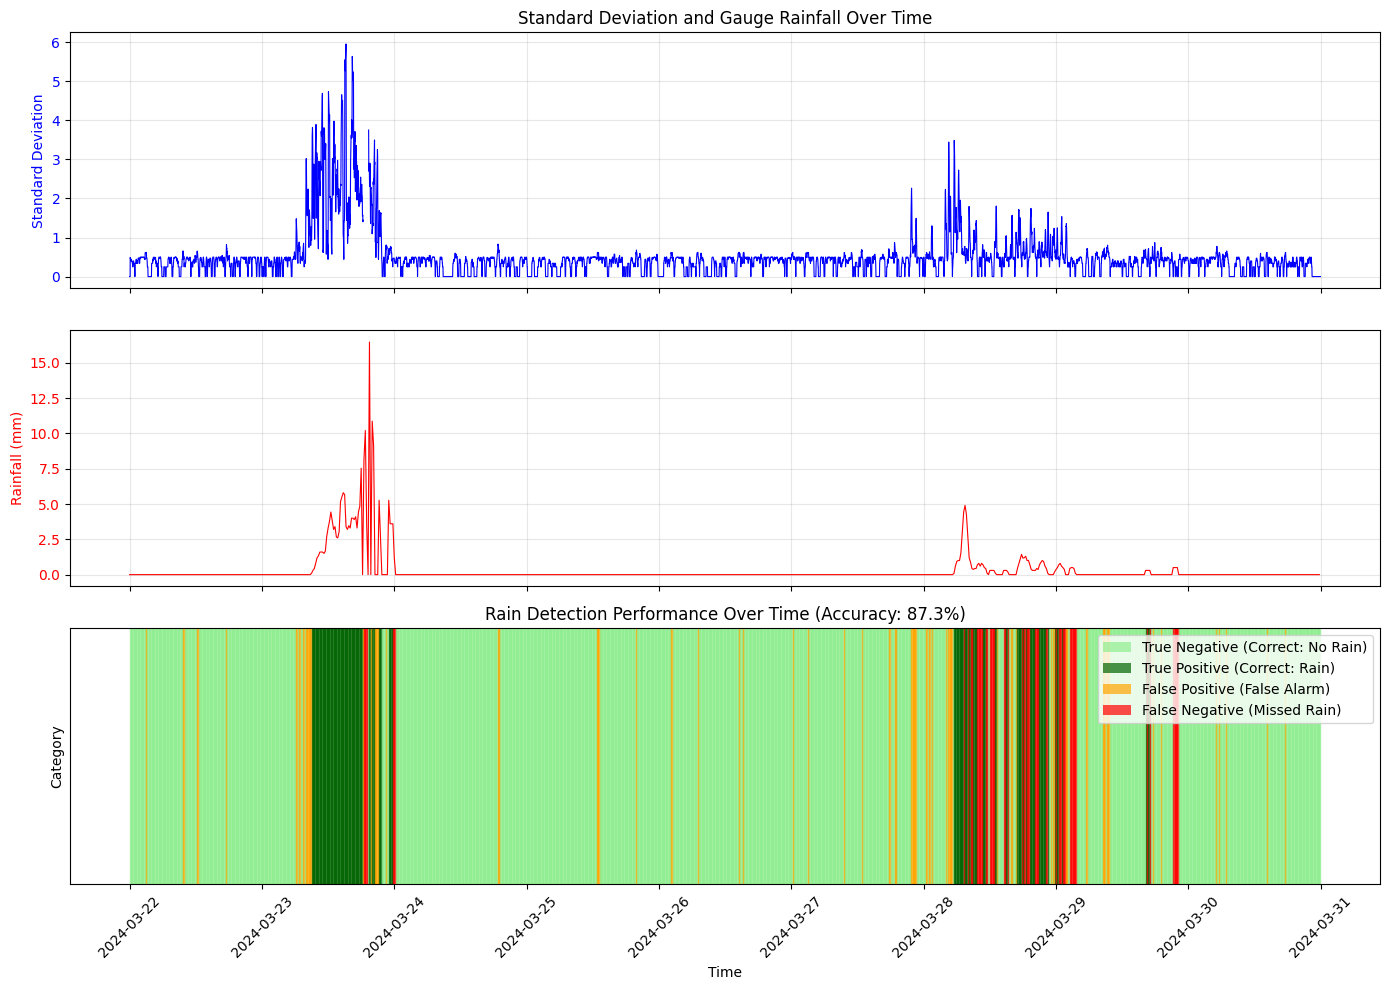

link frequency: 68.04


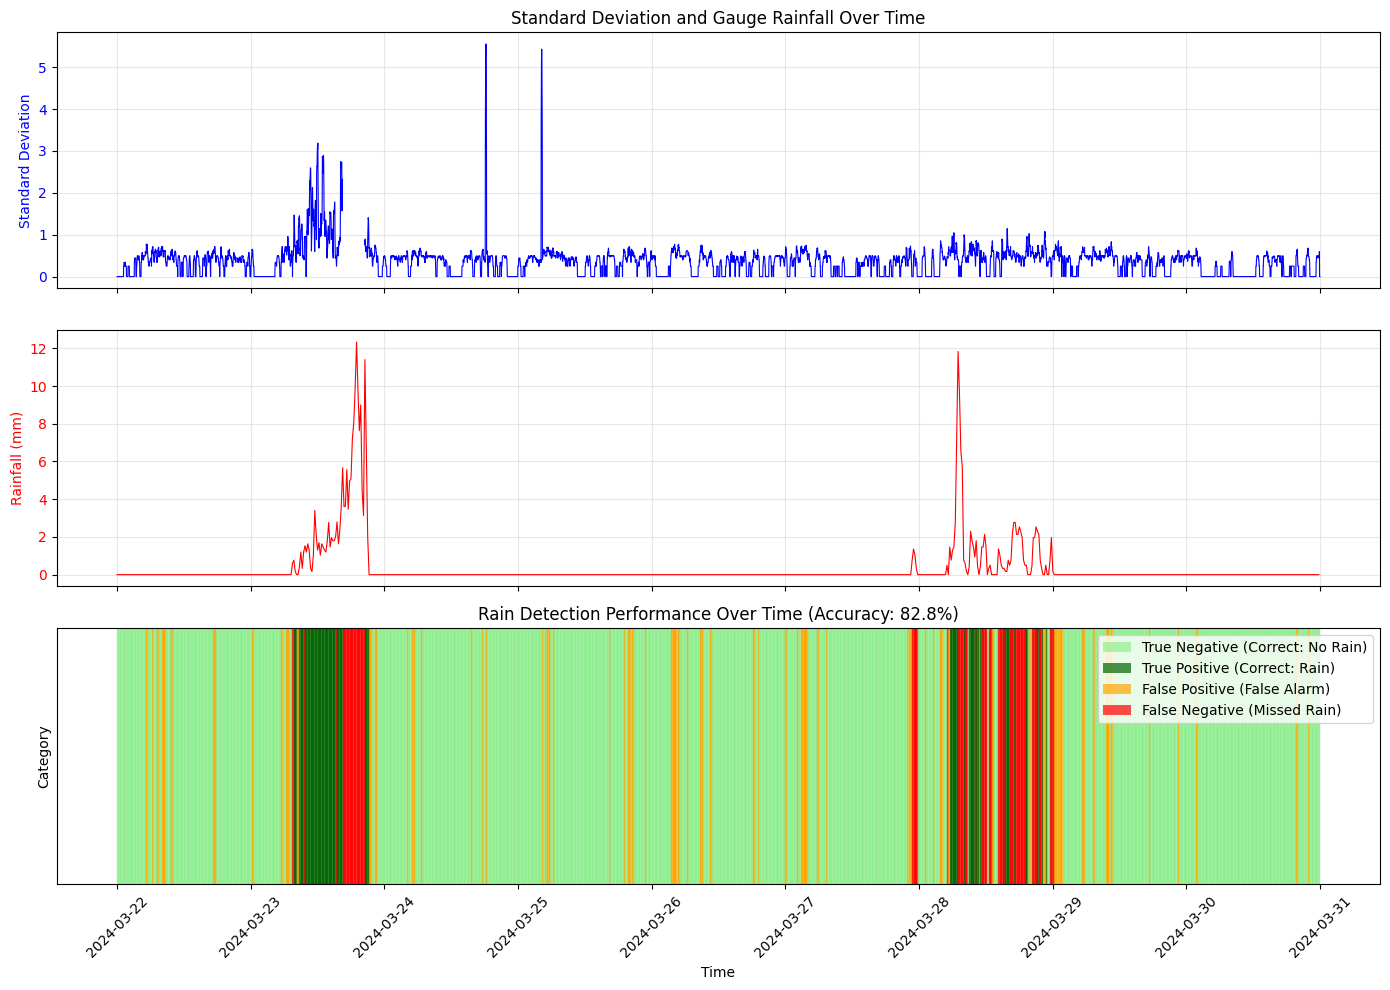

link frequency: 68.04


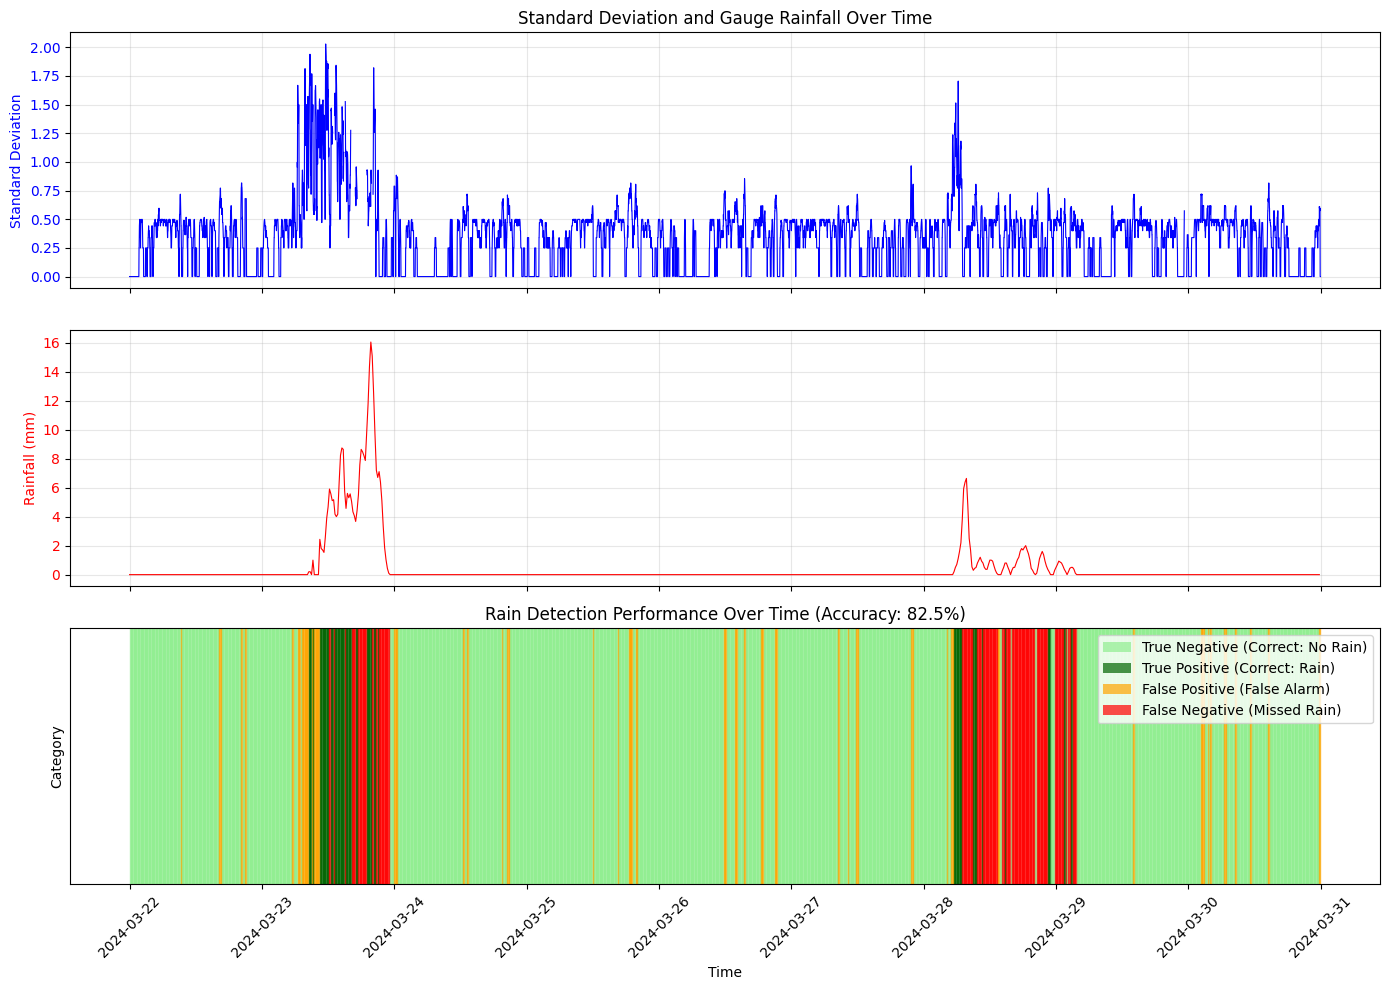

link frequency: 68.04


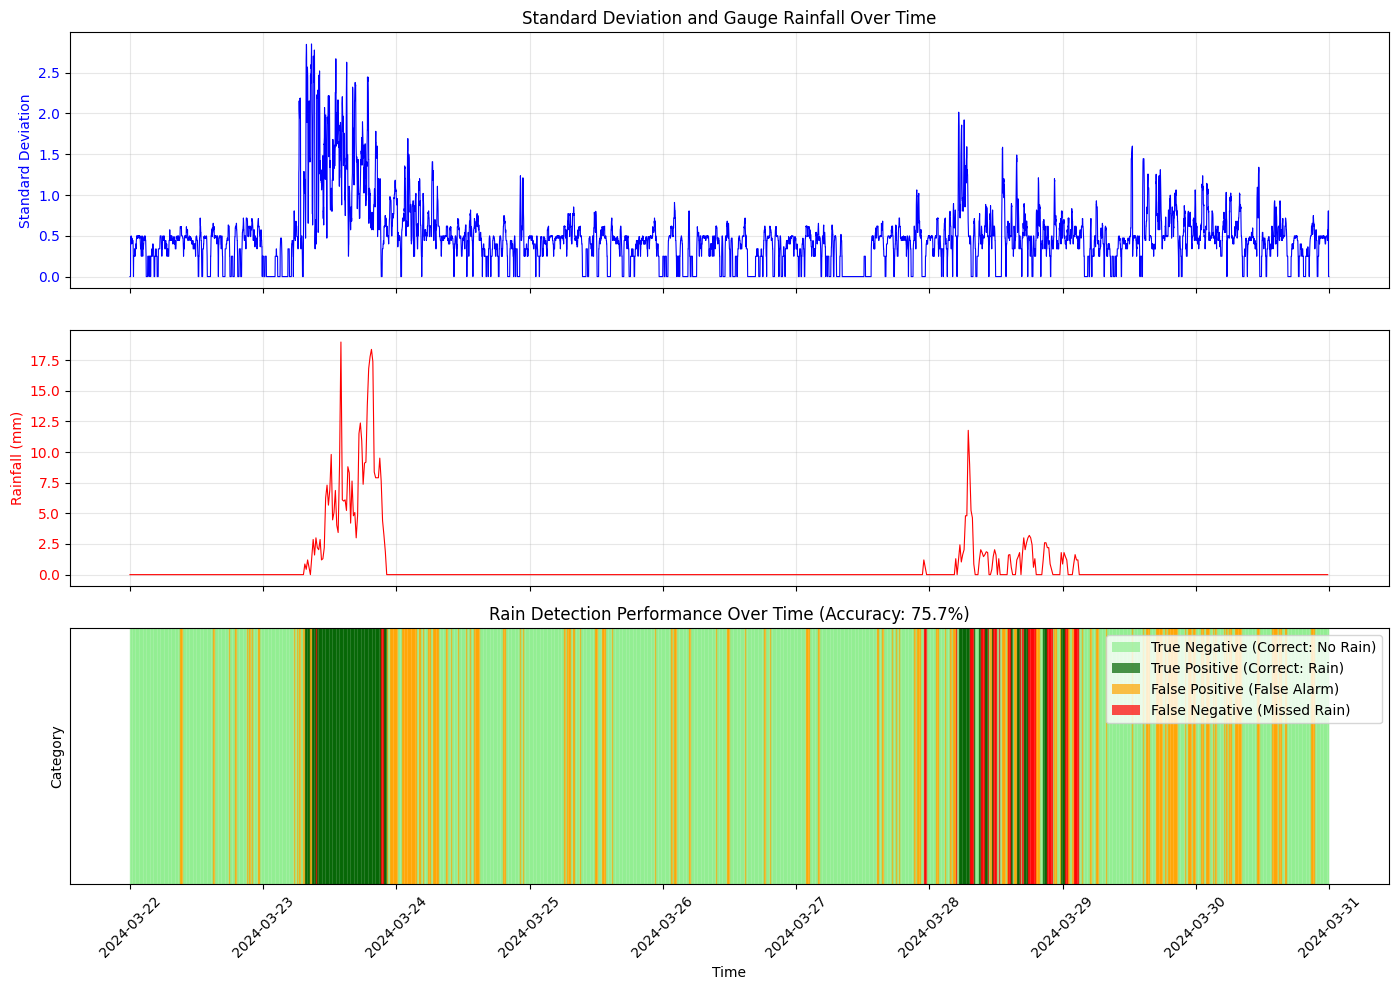

link frequency: 68.04


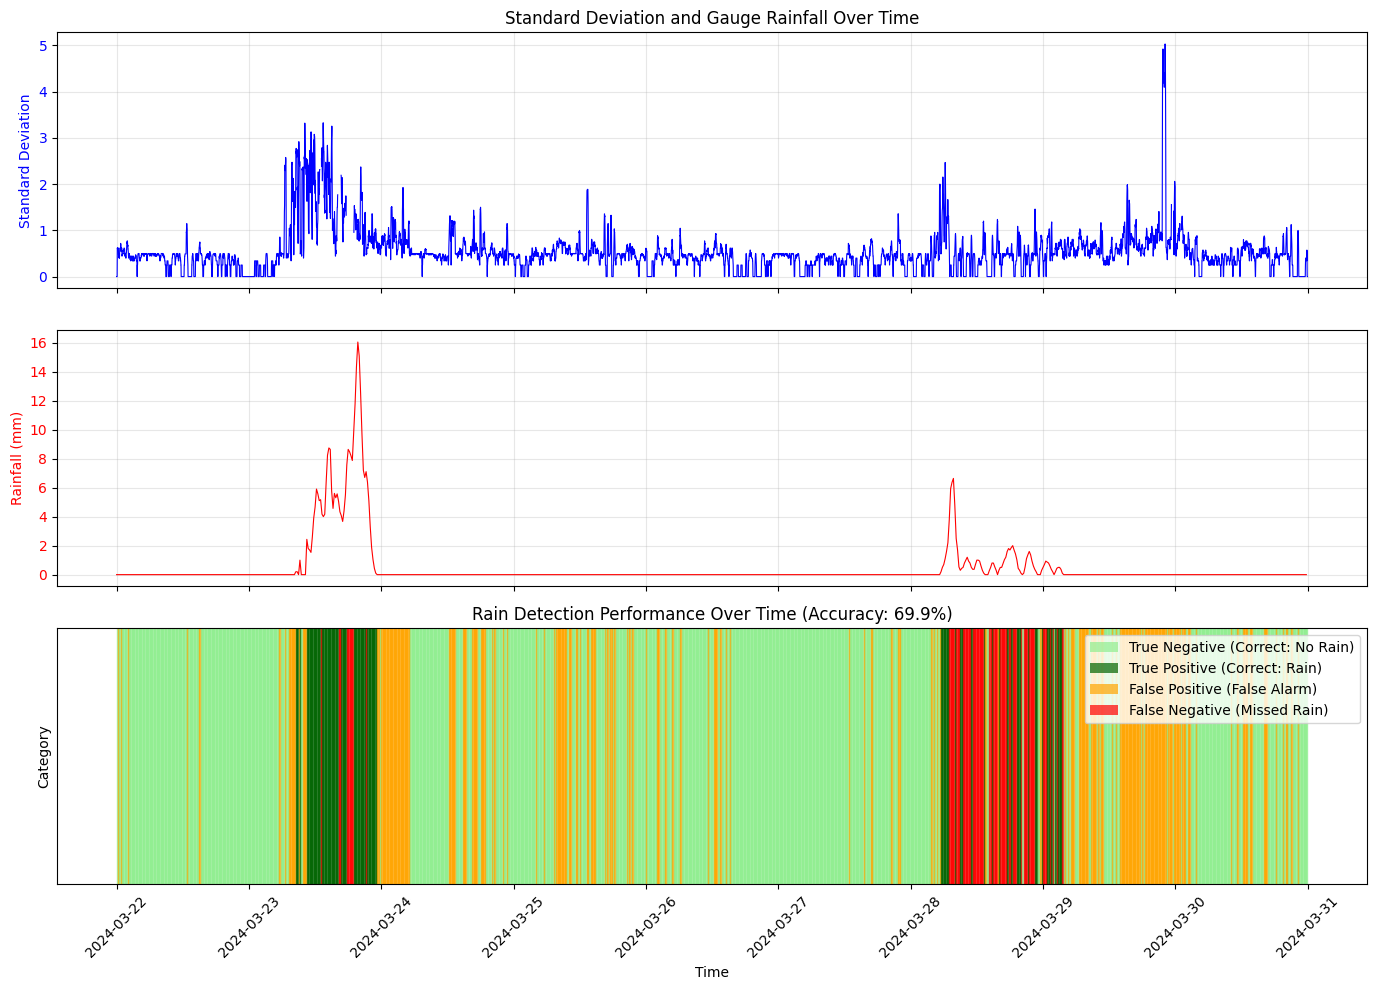

link frequency: 68.04


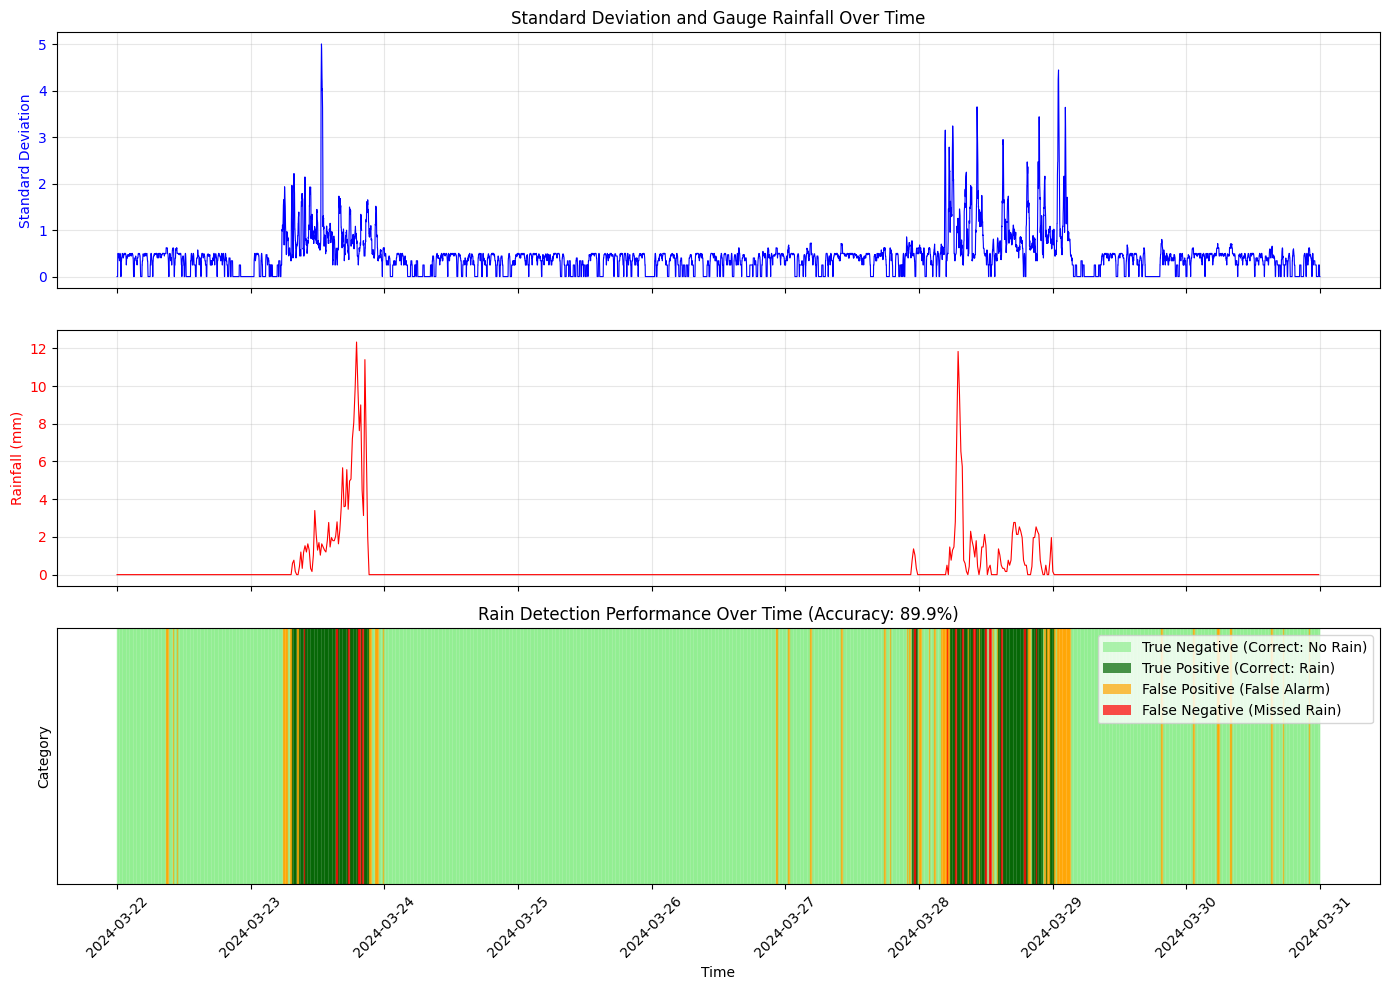

link frequency: 68.04


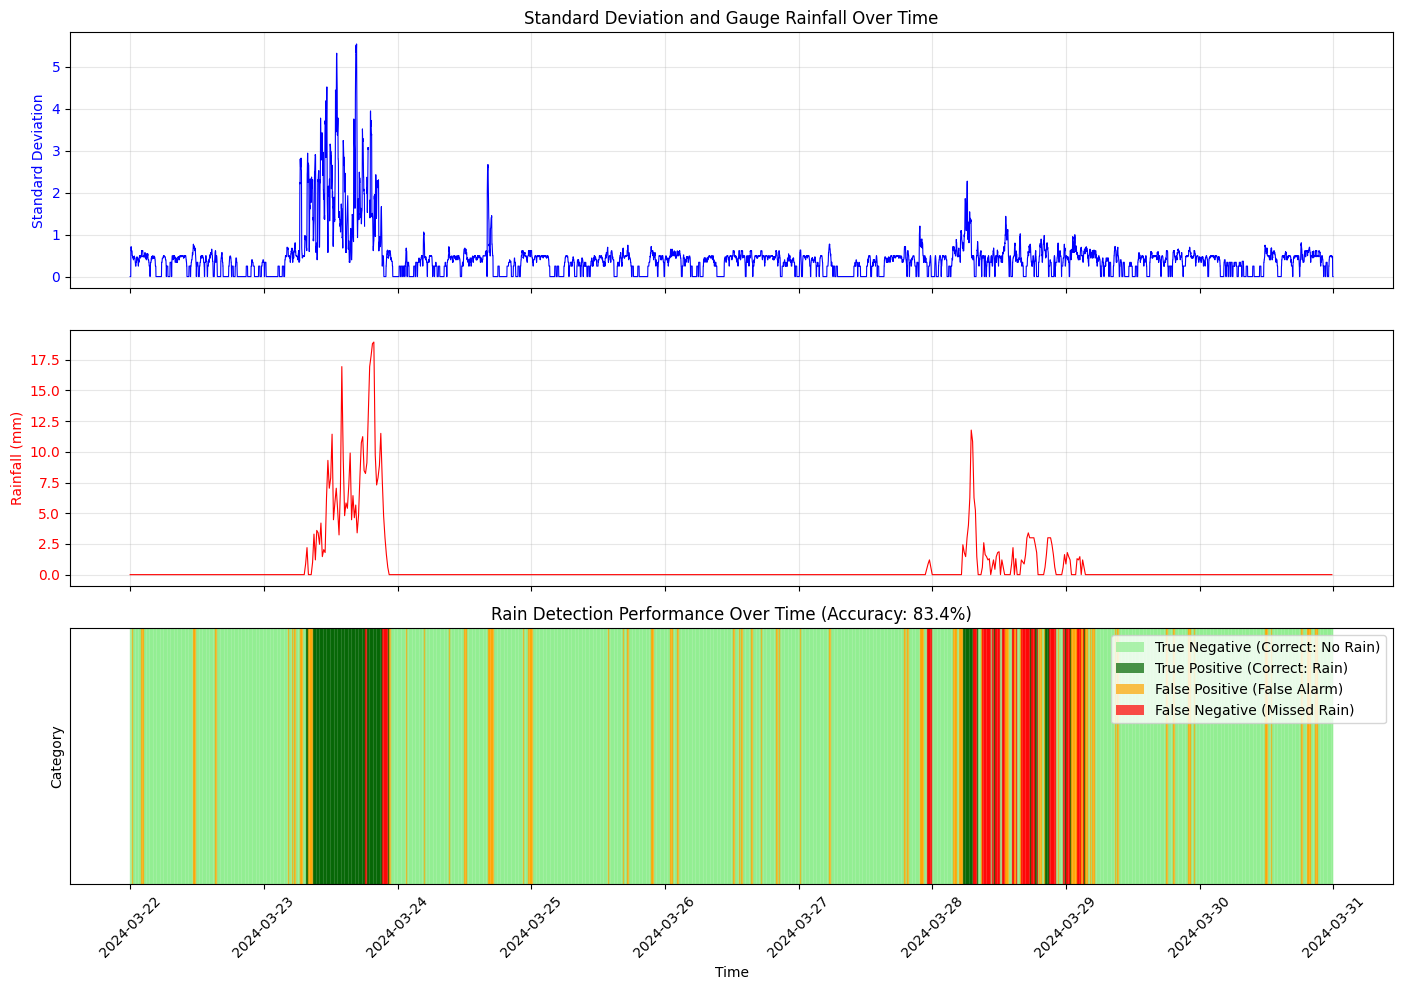

link frequency: 68.04


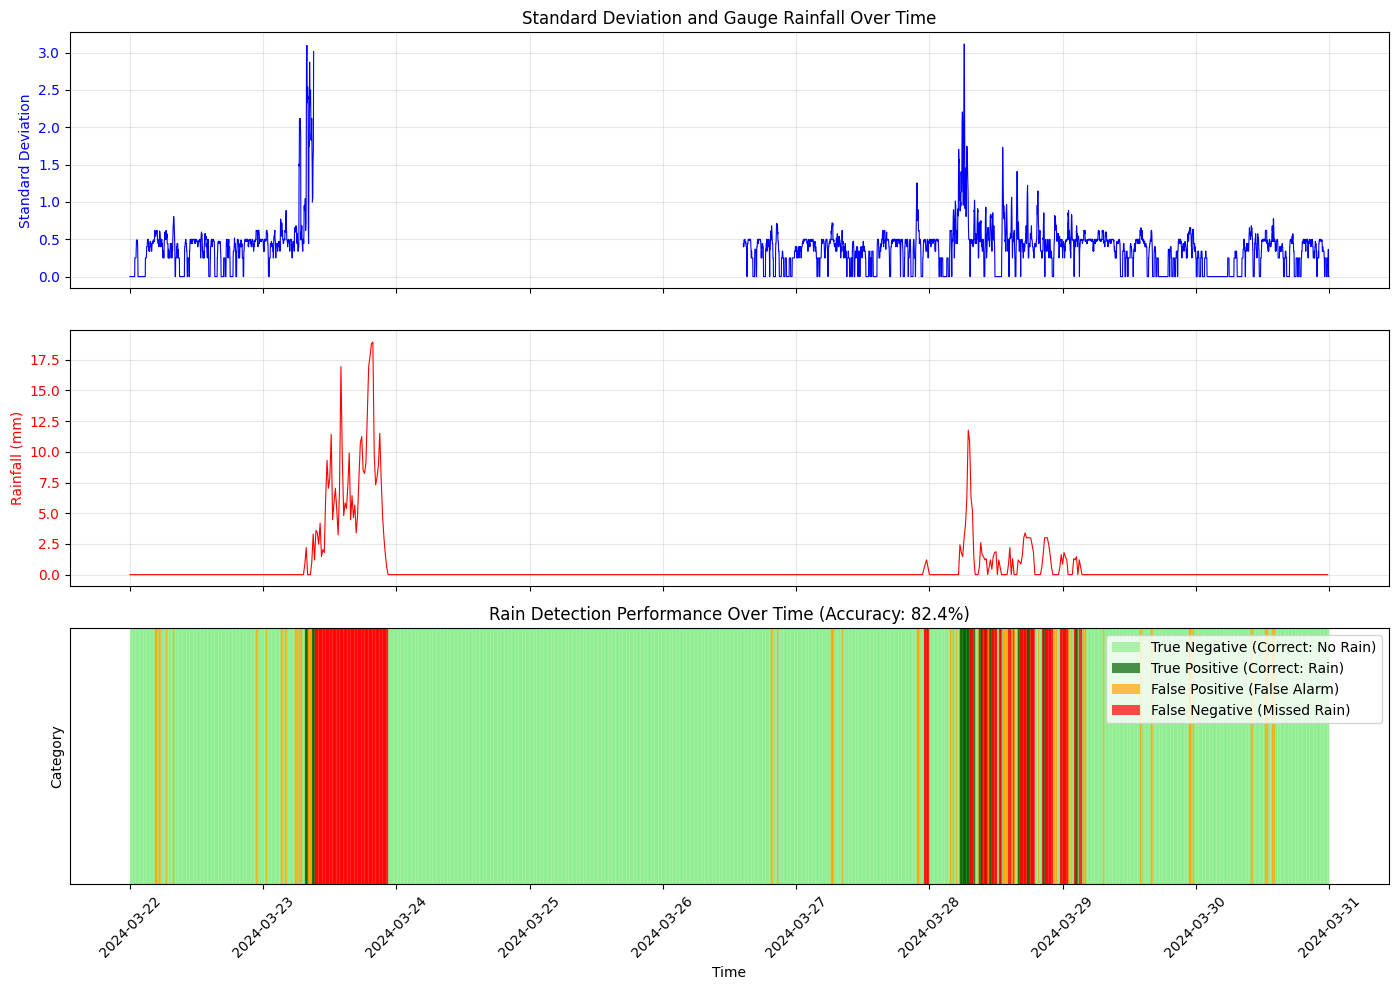

link frequency: 68.04


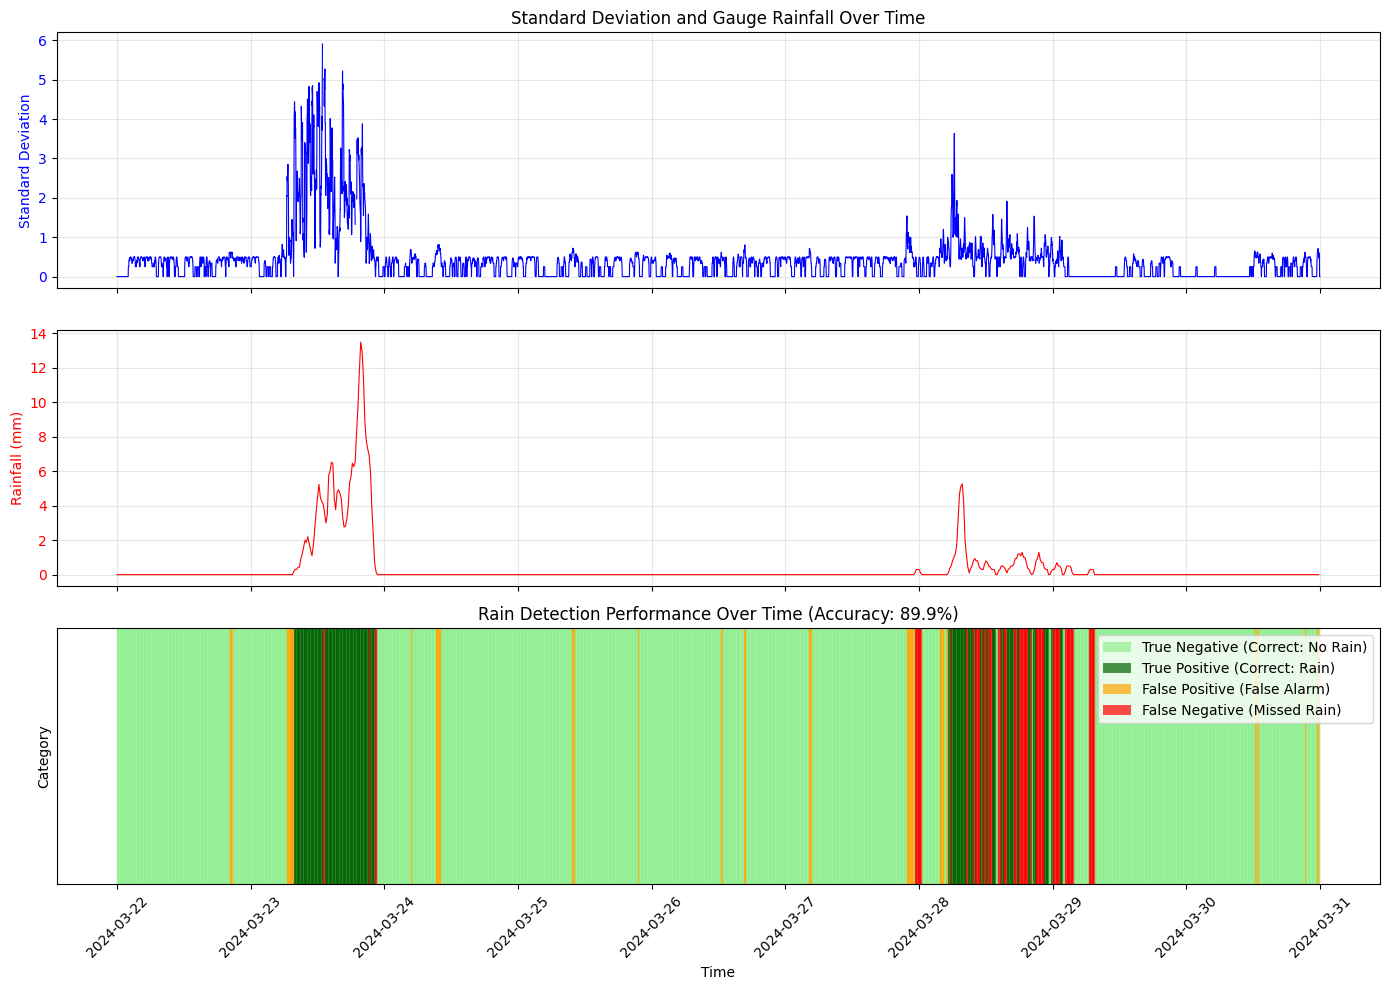

link frequency: 68.04


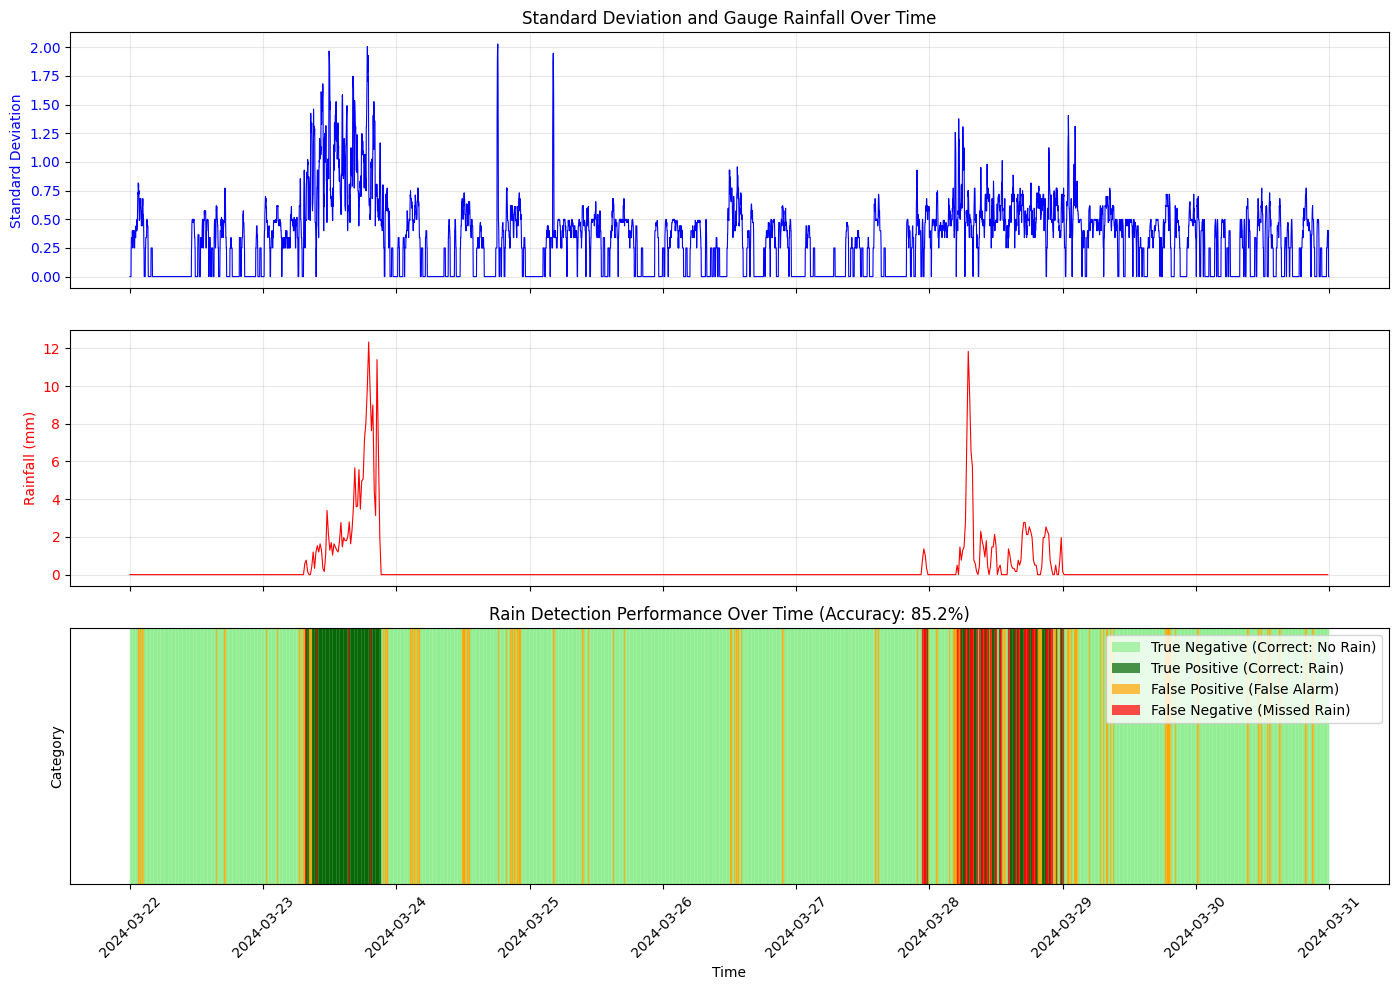

link frequency: 68.04


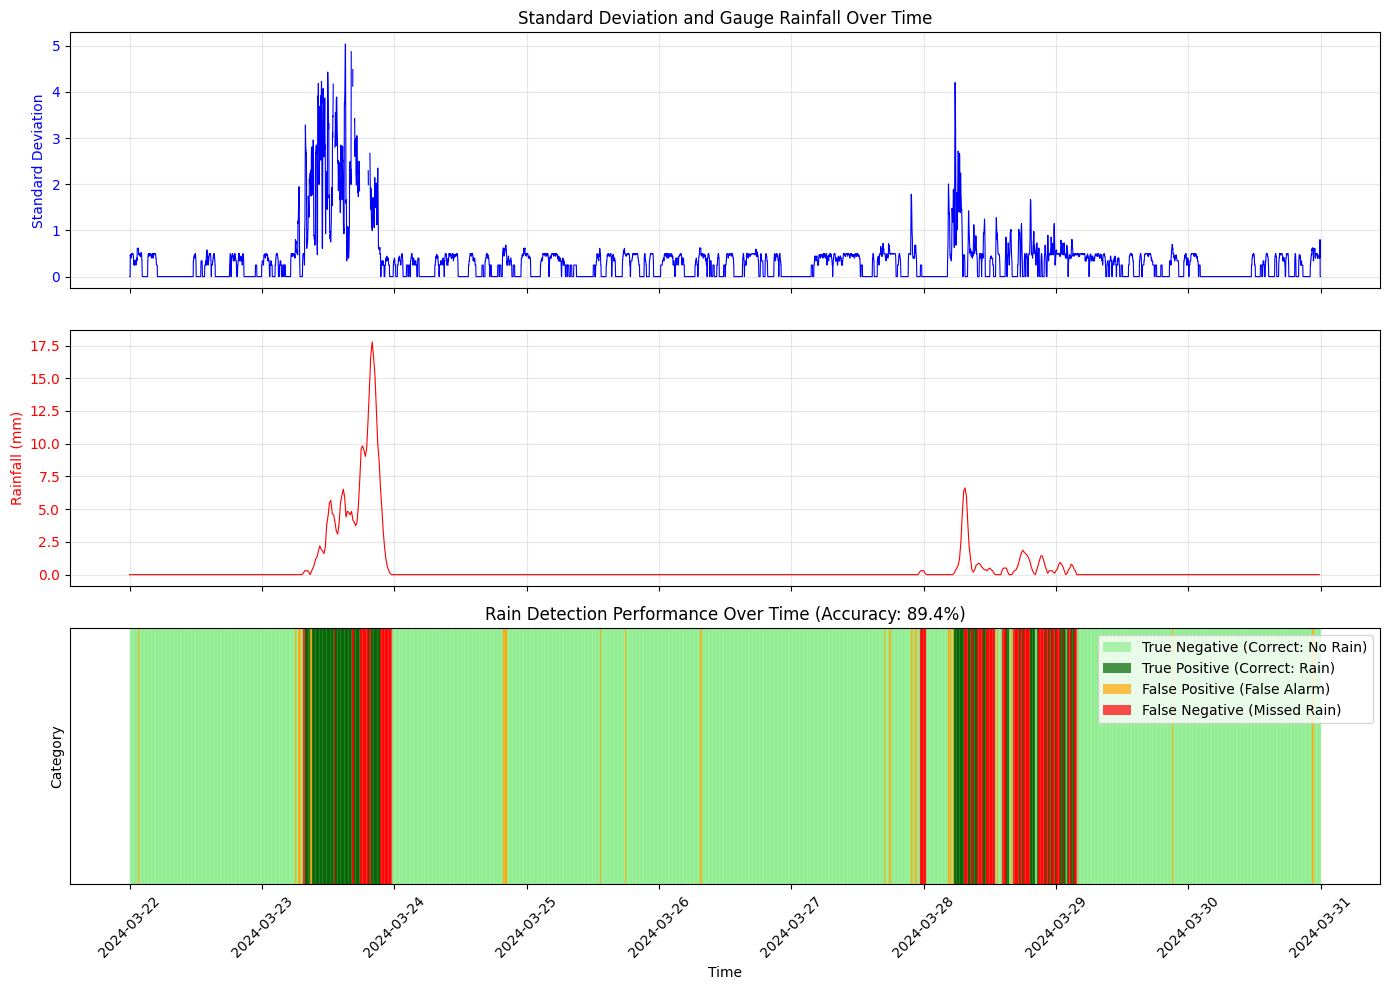

In [512]:
for i in highfreqID2:
    print(f'link frequency: {link_set_short2.get_link(i).meta_data.frequency}')
    rain_detection(link_set_short2.get_link(i), 0.6, 15, True, False)

    Function to check alignment between links and rain gauge

In [470]:
def CheckAlignment(links, indexes, begin, end):
    for i in indexes:
        link = links.get_link(i)
        gauge_time = link.gauge_ref[0].time_array.astype('datetime64[s]')
        gauge_mask = (gauge_time >= np.datetime64(begin)) & (gauge_time <= np.datetime64(end))
        time_filtered_gauge = gauge_time[gauge_mask]
        gauge_filtered = link.gauge_ref[0].data_array[gauge_mask]

        link_time = link.time().astype("datetime64[s]")
        link_mask = (link_time >= np.datetime64(begin)) & (link_time <= np.datetime64(end))
        time_filtered_link = link_time[link_mask]
        rsl_filtered = link.link_rsl[link_mask]

        import matplotlib.pyplot as plt

        fig, ax1 = plt.subplots(figsize=(12, 6))

        # Plot gauge rainfall
        ax1.plot(time_filtered_gauge, gauge_filtered, 'b-', linewidth=2, label='Gauge rainfall')
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Rainfall (mm/hr)', color='b')
        ax1.tick_params(axis='y', labelcolor='b')
        ax1.grid(True, alpha=0.3)
        
        # Plot link RSL on second y-axis (inverted)
        ax2 = ax1.twinx()
        ax2.plot(time_filtered_link, rsl_filtered, 'r-', alpha=0.7, label='Link RSL')
        ax2.set_ylabel('RSL (dBm)', color='r')
        ax2.invert_yaxis()  # Invert so drops go up
        ax2.tick_params(axis='y', labelcolor='r')
        
        plt.title(f'Gauge Rainfall vs Link RSL (Link {i})')
        fig.tight_layout()
        plt.show()

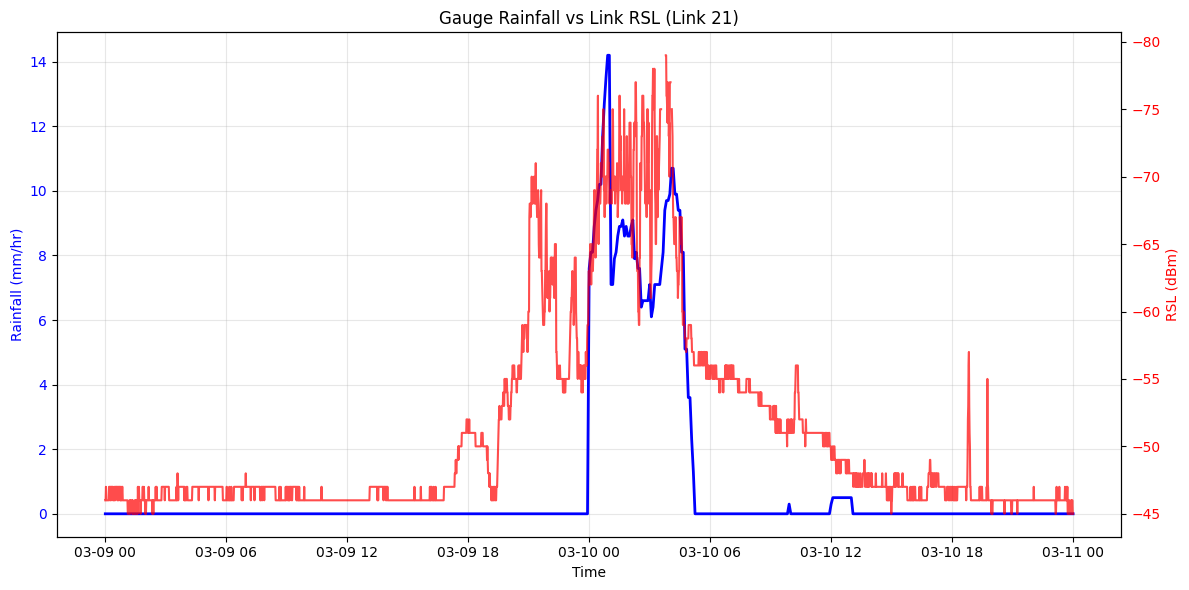

In [480]:
CheckAlignment(link_set, [highfreqID[5]], '2024-03-09', '2024-03-11')